In [1]:
%matplotlib
#%matplotlib inline
import os
import csv
import fnmatch
import numpy as np
import datetime
import re 
import pandas as pd
import matplotlib.pyplot as plt
import math
import pywt
import itertools
from scipy import stats
import statsmodels
from statsmodels.graphics.gofplots import qqplot

pd.options.mode.use_inf_as_na = True

Using matplotlib backend: Qt5Agg


In [2]:
ipaDifficult = list()
ipaMedium = list()
ipaEasy = list()

In [3]:
TimeDwellOrig = 800
TimeFixation = 300

In [4]:
def FixUserKeys(UserKeys_Old):
    # Fix the situation where comma has divided decimals into separate columns
    
    Column_beforeDecimal = [item[2] for item in UserKeys_Old]
    Column_afterDecimal = [item[3] if len(item)>3 else '00' for item in UserKeys_Old]
    
    UserKeys_ProgressPercent = [float(Column_beforeDecimal[i]+'.'+ Column_afterDecimal[i]) for i in 
                                range(0, len(Column_beforeDecimal))]
    UserKeys_Times = [item[0] for item in UserKeys_Old]
    UserKeys_Keys = [item[1] for item in UserKeys_Old]
    
    UserKeys_New = [[UserKeys_Times[ind], UserKeys_Keys[ind], UserKeys_ProgressPercent[ind]] for ind in 
                    range(0, len(UserKeys_ProgressPercent))]
    
    #UserKeys_New = np.concatenate((UserKeys_Times, UserKeys_Keys, UserKeys_ProgressPercent), axis = 0)
    
    
    return UserKeys_New
        

In [5]:
def FixScratchPad(ScratchPad_Old):
    # Fix the situation where comma has divided decimals into separate columns
    
    ScratchPad_Times = [item[0] for item in ScratchPad_Old]
    
    ScratchPad_Phrases = list()
    
    # loop to combine phrases divided by commas
    ScratchPadInd = -1 
    while ScratchPadInd < len(ScratchPad_Old)-1:
        ScratchPadInd = ScratchPadInd + 1
        commasInPhrase = len(ScratchPad_Old[ScratchPadInd])-2
        if commasInPhrase < 1:
            #print(ScratchPad_Old[ScratchPadInd][1])
            ScratchPad_Phrases.append(ScratchPad_Old[ScratchPadInd][1])
            continue
        scratchPadPhrase = ScratchPad_Old[ScratchPadInd][1]
        for phraseJoinNr in range(1, commasInPhrase+1):
            scratchPadPhrase = scratchPadPhrase + ', ' + ScratchPad_Old[ScratchPadInd][1+phraseJoinNr]
        
        ScratchPad_Phrases.append(scratchPadPhrase)
            
        
    ScratchPad_New = [[ScratchPad_Times[ind], ScratchPad_Phrases[ind]] for ind in 
                    range(0, len(ScratchPad_Times))]
    
    #UserKeys_New = np.concatenate((UserKeys_Times, UserKeys_Keys, UserKeys_ProgressPercent), axis = 0)
    
    #print(ScratchPad_New)
    return ScratchPad_New

In [6]:
def stimPhrasesEdit_expt2019Jan(PhraseLog, subjName):
    
    # Now extract phrases from the phrase file
    phraseStim_Phrases = [item[1] for item in PhraseLog]
    phraseStim_PhrasesReduced = sorted(set(phraseStim_Phrases), key=phraseStim_Phrases.index)
    
    PhraseLogReduced= list()
    ind = -1
    
    for i in phraseStim_PhrasesReduced:
        ind = ind + 1

        if ind == len(phraseStim_PhrasesReduced)-1:
            if subjName == 'sa\Test_woChinRest\p1':
                PhraseLogReduced.append([phraseLog[phraseStim_Phrases.index(i)][0], i[0:31]])
                
            elif subjName == 'rh\Test_wChinRest\p1':
                PhraseLogReduced.append([phraseLog[phraseStim_Phrases.index(i)][0], i[0:-9]])
            else:
                PhraseLogReduced.append([phraseLog[phraseStim_Phrases.index(i)][0], i])
        else:
            PhraseLogReduced.append([phraseLog[phraseStim_Phrases.index(i)][0], i])
            
    del PhraseLogReduced[0]
    del PhraseLogReduced[0]
    

    
    if PhraseLogReduced[-1][1] == 'THE EXPERIMENT IS NOW DONE':
        del PhraseLogReduced[-1]
        
    if subjName == 'rh\Test_wChinRest\p2':
        #print(PhraseLogReduced[2])
        del PhraseLogReduced[2]
        #print(PhraseLogReduced[-1])
        del PhraseLogReduced[-1]
        
    #if subjName == 'sa\Test_woChinRest\p1' or subjName == 'rh\Test_wChinRest\p1':
    #    del PhraseLogReduced[-1]
        
    if subjName == 'sa\Test_woChinRest\p2':
        del PhraseLogReduced[3]
        del PhraseLogReduced[1]
        del PhraseLogReduced[0]
        
    return PhraseLogReduced
    
    

In [7]:
def scratchPadPhraseEdit(phraseUser, subjName):
    phraseUserEnd = list()
    
    
    #print(phraseUser)
    for row_ind in range(0, len(phraseUser)):
        if row_ind!= 0 and phraseUser[row_ind][1] == '':
            if len(phraseUser[row_ind-1][1])>10:
                phraseUserEnd.append(phraseUser[row_ind-1])
                #print(phraseUser[row_ind-1])
    
    if subjName == 'sa\Test_woChinRest\p1':
        phraseUserEnd.append([phraseUser[-1][0], phraseUser[-1][1][0:35]])
    
    if subjName == 'rh\Test_wChinRest\p1':
        phraseUserEnd.append(phraseUser[-1])
        
    # remove first trial of text composition
    del phraseUserEnd[0]
        
    if subjName == 'rh\Test_wChinRest\p2':
        #print(phraseUserEnd[-2])
        del phraseUserEnd[-2]
        
    return phraseUserEnd

In [8]:
# find minimum cost and the operations that give rise to it
def minValnInd(costOptions, flagSame):
    operator = list()
    unique_entries = set(costOptions)
    valInd = { value : [ i for i, v in enumerate(costOptions) if v == value ] for value in unique_entries }
    keyVal = list(valInd.keys())
    min_value = min(keyVal)
    
    if 0 in valInd[min_value]:
        operator.append('D')
    if 1 in valInd[min_value]:
        operator.append('I')
    if 2 in valInd[min_value]:
        if flagSame == 0:
            operator.append('S')
        else:
            operator.append('N')   
    flagSame = None    
    return min_value, ''.join(operator)

In [9]:
# Function to compute the MSD, with cost of 2 for substitution and 1 for insertion and deletion
costSub = 2
costIns = 1
costDel = 1

def levenshteinDist(phraseIn, phraseOut):
    
    lenStim = len(phraseIn)
    lenUser = len(phraseOut)
    costMatrix = np.zeros((lenStim+1, lenUser+1), dtype=int)
    MSDoperation = np.empty([lenStim+1, lenUser+1], dtype="U4")
    costMatrix[0,0:] = range(0, lenUser+1)
    costMatrix[0:,0] = range(0, lenStim+1)
    MSDoperation[0,0:] = 'I'
    MSDoperation[0:,0] = 'D'
    
    for i in range(1, len(phraseIn)+1):
        iP = i - 1
        for j in range(1, len(phraseOut)+1):
            jP = j - 1
            if phraseIn[iP].lower() == phraseOut[jP].lower():
                # Define the possible cost array
                costOptionArray = [costMatrix[i,j-1]+costDel, costMatrix[i-1,j]+costIns, costMatrix[i-1,j-1]] 
                flagSame = 1
            else:
                costOptionArray = [costMatrix[i,j-1]+costDel, costMatrix[i-1,j]+costIns, costMatrix[i-1,j-1]+costSub]
                flagSame = 0
            costMatrix[i,j], MSDoperation[i][j] = minValnInd(costOptionArray, flagSame)
    #print(costMatrix)
    return costMatrix[-1,-1]


In [10]:
def ComputeDwellTime(userKeys):
    # modify userKeys to include a column of time instead of progress pct, which is dependent on the then dwell time
    
    timeDwell = TimeDwellOrig
    nKey = -1
    for key in userKeys:
        nKey = nKey + 1
        #print(key[1])
        if key[1] == 'IncreaseDwellTime':
            if float(key[2]) == 1:
                timeDwell = timeDwell + 100
        elif key[1] == 'DecreaseDwellTime':
            #print(key[2])
            if float(key[2]) == 1:
                timeDwell = timeDwell - 100
        else:
            userKeys[nKey].append(str(float(key[2])*timeDwell))
    
    return userKeys

In [11]:
def timeTypingStart(userKeys):
    # From the user keys, find when the user actually starts typing, after having looked at the phrase and all the other 
    # function keys
    
    timeTypingStartInd = 0
    
    timeTypingStartIndList = list()
            
    timeUserTimeInd = 0
    
    ind = 0
    # Get start time of first trial
    
    while ind < len(userKeys):
        #print(len(userKeys[ind][1]))
        if len(userKeys[ind][1]) > 1:
            ind = ind + 1
        else:
            timeTypingStartInd = ind
            timeTypingStartIndList.append(ind)
            break
    
    #print(timeTypingStartInd)
    # Get every next phrase start timings
    while ind < len(userKeys):
        
        if userKeys[ind][1] == 'NextPhrase' and float(userKeys[ind][2]) == 1:
            
            #timeTypingStartIndList.append(ind+1)
            for ind2 in range(ind+1, len(userKeys)):
                if len(userKeys[ind2][1]) > 1:
                    ind = ind + 1
                    continue
                elif userKeys[ind2][1] == 'NextPhrase' and float(userKeys[ind][2]) == 1:
                    ind = ind + 1
                    continue
                else:
                    ind = ind2
                    timeTypingStartIndList.append(ind)
                    break
                    
        else:
            ind = ind + 1
            
    #print(timeTypingStartIndList)
    
    return timeTypingStartIndList

In [12]:
def phrasesTyped(your_list, timeList, userKeys, stimPhraseList, SubjName):
    # Find entries in scratchpad (end of each trial)
    
    IndexNotInclude = list()
    PhraseList = list()
    TypingSpeed = list()

    # After every complete phrase, the next phrase is empyty ''
    for row_ind in range(0, len(your_list)):
        if 'sa\Test_woChinRest\p1' in SubjName or 'rh\Test_wChinRest\p1' in SubjName:
            if row_ind == len(your_list)-1:
                IndexNotInclude.append(row_ind)
                #print([your_list[row_ind-1][1]])
                #print(your_list[row_ind-1][1])
        if your_list[row_ind][1] == '':
            if row_ind == 1:# first empty phrase needs to be not considered , at least for most of the subjects
                #print(your_list[row_ind-1][1])
                continue
            if your_list[row_ind][1] == your_list[row_ind-1][1]:
                continue
            IndexNotInclude.append(row_ind)
            #print([your_list[row_ind-1][1]])
    
    #print(len(IndexNotInclude))
    #print('IndexNotInclude', IndexNotInclude)
    
    firstTrial = IndexNotInclude[0]
    # Find the time taken for each phrase  
    # remove the indices that are due to deleting phrase written to make the scrathpad empty
    IndexNotInclude_Difference = [t - s for s, t in zip(IndexNotInclude, IndexNotInclude[1:])]
    #print('IndexNotInclude_Difference', IndexNotInclude_Difference)
    IndexNotInclude = [IndexNotInclude[ind+1] for ind in range(0,len(IndexNotInclude_Difference)) if IndexNotInclude_Difference[ind]>12]
    IndexNotInclude_DifferenceLeft = [IndexNotInclude_Difference[ind] for ind in range(0,len(IndexNotInclude_Difference)) if IndexNotInclude_Difference[ind]>12]

    #print(len(IndexNotInclude_DifferenceLeft))
    #print('IndexNotInclude_DifferenceLeft', IndexNotInclude_DifferenceLeft)
    
    if 'sa\Test_woChinRest\p1' in SubjName:
        IndexNotInclude = IndexNotInclude[1:]
    if 'rh\Test_wChinRest\p2' in SubjName:
        del IndexNotInclude[-2]
        IndexNotInclude.insert(0, firstTrial)
        
    if 'sa\Test_woChinRest\p2' in SubjName:
        IndexNotInclude.insert(0, firstTrial)
        
    #print('length', len(userKeys[1]))
    
    for indPhrase in range(0, len(IndexNotInclude)):
        #print(indPhrase)
        startPhrase = timeList[indPhrase]    
 
        endPhrase = IndexNotInclude[indPhrase]-1
        headStartPhrase,sep,tail = userKeys[startPhrase][0].partition('+')
        headEndPhrase,sep,tail = your_list[endPhrase][0].partition('+')
        timeTaken = datetime.datetime.strptime(re.sub('[:.T]','-',headEndPhrase[:-1]), "%Y-%m-%d-%H-%M-%S-%f") - datetime.datetime.strptime(re.sub('[:.T]', '-', headStartPhrase[:-1]), "%Y-%m-%d-%H-%M-%S-%f") + datetime.timedelta(0, 0, float(userKeys[startPhrase][3]))
        phraseTyped = your_list[endPhrase][1]
        #print(userKeys[startPhrase][0], ' to ', your_list[endPhrase][0], phraseTyped)
        PhraseList.append([timeTaken, phraseTyped])
            

    
    # Compute the total time for the phrase and the total number of words typed during that time (1 word = 5 characters, including space)
    timeAdd = datetime.datetime.strptime('1000-1-1-0-00-00-000000',"%Y-%m-%d-%H-%M-%S-%f")
    characterLen = 0
    
    #print(IndexNotInclude)
    timeTrial_list = list()
    characters = list()
    for indPhrase in range(0, len(IndexNotInclude)):
        timeAdd += PhraseList[indPhrase][0]
        timeTrial_list.append(PhraseList[indPhrase][0])
        characters.append(len(PhraseList[indPhrase][1]))
        
    TimeTaken = (timeAdd.microsecond/1000000 + timeAdd.second)/60 + timeAdd.minute
    
    return characters, timeTrial_list, TimeTaken
    

In [13]:
def OptiKeyTypingTime(UserKeys):
    
    TimeTyping = dict()
    
    time1, t1, t2 = UserKeys[0][0].partition('+')
    startTime = datetime.datetime.strptime(re.sub('[:.T]','-',time1[:-1]), "%Y-%m-%d-%H-%M-%S-%f")
    
    time2, t1, t2 = UserKeys[-1][0].partition('+')
    endTime = datetime.datetime.strptime(re.sub('[:.T]','-',time2[:-1]), "%Y-%m-%d-%H-%M-%S-%f")
    
    TimeTyping['startTime'] = startTime
    TimeTyping['endTime'] = endTime
    
    return TimeTyping

In [14]:
def FindTrialEndTimes(KeysSelected, timeTyping):
    # function to find start and end of tasks in experiments
    timeStartEnd = list() # format of this list will be: [startTime1, endTime1/startTime2, endTime2/startTime3, ..., endTimeN]
    
    timeStartEnd.append(timeTyping['startTime'])
    
    nTrial = 1
    
    for keys in KeysSelected:
        
        if keys[1] == 'NextPhrase':
            time1, t1, t2 = keys[0].partition('+')
            endTimeTrial = datetime.datetime.strptime(re.sub('[:.T]','-',time1[:-1]), "%Y-%m-%d-%H-%M-%S-%f")
            timeStartEnd.append(endTimeTrial)
    
    
    timeStartEnd.append(timeTyping['endTime'])
    
    
    return timeStartEnd

In [15]:
# function to convert list of date and time into datetime format list
def timeConversion(timeStrList):
    timeList = list()
    for time in timeStrList:
        time1, t1, t2 = time.partition('+')
        timeList.append(datetime.datetime.strptime(re.sub('[:.T]','-',time1[:-1]), "%Y-%m-%d-%H-%M-%S-%f"))
    return timeList

In [16]:
# This function will return the datetime in items which is the closest to the date pivot
def nearestTimePoint(dates, date):
    
    for d in dates:
        if d < date:
            nearestTP = d
        else:
            continue
    try: 
        nearestTP
        nearestTPind = dates.index(nearestTP)
    except:
        nearestTP = 0
        nearestTPind = -1
        
    return nearestTP, nearestTPind

In [17]:
def CreateTimeEpochsOfTrials(TimeStartEndMixed, UserKeys):
    # function to use list of mixed start and end times of trials and keys looked at by user to create trial epochs
    
    TimeEpochTrial = dict()
    TimeEpochTrial['Start'] = list()
    TimeEpochTrial['End'] = list()
    
    # Create list of times in userKeys to be able to use function 'nearestTimePoint'
    UserKeysStrTimes = [item3[0] for item3 in UserKeys]
    UserKeysTimes = timeConversion(UserKeysStrTimes)
    
    Flag_FoundSleepKey = 0 # Flag to indicate finding sleep key
    
    n = -1
    for time in TimeStartEndMixed:
        n = n + 1
        Flag_FoundSleepKey = 0
        
        if n == 0: # first time is only start time for the first trial
            TimeEpochTrial['Start'].append(time)
            continue
        elif n == len(TimeStartEndMixed)-1: # last time is only the end time for last trial
            
            TimeEpochTrial['End'].append(time)
            
        else: # the middle elements need to be divided into start and end
            TimeEpochTrial['End'].append(time)
            
            timeCheck = time
            
            # find the time in userkeys. Keep going to the previous element till you reach start of selection of
            # nextPhrase key
            while Flag_FoundSleepKey < 1:
                
                nearestToTrialStartTime, nearestToTrialStartInd = nearestTimePoint(UserKeysTimes, timeCheck)
                indCheck = nearestToTrialStartInd
                
                if 'NextPhrase' not in UserKeys[indCheck][1]:
                    TimeEpochTrial['Start'].append(nearestToTrialStartTime)
                    Flag_FoundSleepKey = 1
                    break
                else:
                    indCheck = indCheck - 2 # 2 added instead of 1, to allow nearestTimePoint to find the one before this
                    timeCheck = UserKeysTimes[indCheck]
                    
                
    return TimeEpochTrial      
            

In [18]:
def DwellTimeForBaseline(UserKeys_wDwellTime):
    
    DwellTime = list()
    
    for key in UserKeys_wDwellTime:
        if key[1] == 'NextPhrase':
            #print('NextPhrase found at ', key[2])
            if key[2] == 1:
                DwellTime.append(key[3])
                
    return DwellTime

In [19]:
def Convert2ColumnSizesTo1(GazeLog):
    # function to convert pupilsizes from 2 columns for every pupil due to comma use instead of decimal, 
    # to proper pupil sizes
    
    PupilLogL = list()
    PupilLogR = list()
    
    PupilLogL_beforeDecimal = [item4[-5] if 'Invalid' not in item4 else 'nan' for item4 in GazeLog]
    PupilLogL_afterDecimal = [item4[-4] if 'Invalid' not in item4 else 'nan' for item4 in GazeLog]
    PupilLogR_beforeDecimal = [item4[-2] if 'Invalid' not in item4 else 'nan' for item4 in GazeLog]
    PupilLogR_afterDecimal = [item4[-1] if 'Invalid' not in item4 else 'nan' for item4 in GazeLog]
    
    for i in range(0, len(PupilLogL_beforeDecimal)):
        if 'Valid' not in PupilLogL_beforeDecimal[i] and 'Valid' not in PupilLogL_afterDecimal[i]:
            if 'nan' not in PupilLogL_beforeDecimal[i] and 'nan' not in PupilLogL_afterDecimal[i]:
                PupilLogL.append(float(PupilLogL_beforeDecimal[i]+'.'+PupilLogL_afterDecimal[i]))
            else:
                PupilLogL.append(np.nan)
        else:
            # Rarely, the pupil size is a whole number
            PupilLogL.append(np.nan) # we will ignore the row, since there is no way of automatically knowing which - 
            # right or left eye has whole number pupil size
    
    for i in range(0, len(PupilLogR_beforeDecimal)):
        if 'Valid' not in PupilLogR_beforeDecimal[i] and 'Valid' not in PupilLogR_afterDecimal[i]:
            if 'nan' not in PupilLogR_beforeDecimal[i] and 'nan' not in PupilLogR_afterDecimal[i]:
                PupilLogR.append(float(PupilLogR_beforeDecimal[i]+'.'+PupilLogR_afterDecimal[i]))
            else:
                PupilLogR.append(np.nan)
        else:
            # Rarely, the pupil size is a whole number
            PupilLogL.append(np.nan) # we will ignore the row, since there is no way of automatically knowing which - 
            # right or left eye has whole number pupil size
            
    # if one of the pupils are nan, the other one is converted too
    nPupil = -1
    for pupilL in PupilLogL:
        nPupil = nPupil + 1
        if np.isnan(pupilL):
            if nPupil < len(PupilLogR):
                if not np.isnan(PupilLogR[nPupil]):
                    PupilLogR[nPupil] = np.nan
            else:
                del PupilLogL[len(PupilLogR):]
                
    nPupil = -1
    for pupilR in PupilLogR:
        nPupil = nPupil + 1
        if np.isnan(pupilR):
            if nPupil < len(PupilLogL):
                if not np.isnan(PupilLogL[nPupil]):
                    PupilLogL[nPupil] = np.nan
            else:
                del PupilLogR[len(PupilLogL):]
                
    #print(len(PupilLogL), len(PupilLogR))
    
    return PupilLogL, PupilLogR

In [20]:
def PupilSizeFromTrialTimes(TimeTrial, TimeGazeLog, TimeInternalGazeLog, PupilSizeLogL, PupilSizeLogR):
    # find pupil sizes from the start and end time given
    
    # find start and end time in gazeLog
    timeStart, timeStartInd = nearestTimePoint(TimeGazeLog, TimeTrial[0])
    timeEnd, timeEndInd = nearestTimePoint(TimeGazeLog, TimeTrial[1])
    
    pupilSize_TrialL = PupilSizeLogL[timeStartInd: timeEndInd]
    pupilSize_TrialR = PupilSizeLogR[timeStartInd: timeEndInd]
    
    TimeInternal_Trial = TimeInternalGazeLog[timeStartInd: timeEndInd]
    
    TimeGaze_Trial = TimeGazeLog[timeStartInd: timeEndInd]
    
    return pupilSize_TrialL, pupilSize_TrialR, TimeGaze_Trial, TimeInternal_Trial
    

In [21]:
def filterBlinks(pupilData, timeInDatetime_trial, timeInS_Trial):
    # filter any blinks and nan values lasting around 250ms (on average)
    # http://faculty.washington.edu/chudler/facts.html
   
    # recording extra blink information - duration and frequency
    blinkDurationList = list()
    blinkTimeList = list()
    blinkCount = 0
    nonBlinkCount = 0
    nonBlinkTimeList = list()
    timeRemove = 0
    
    # blink is every nan value in the range of 100-400ms 
    # 250 ms (23 samples) before and after the blink will also be removed
    extraBlinkSamples = 23    
    
    # remove single missing data, that are due to hardware error
    missingVal_Single = np.argwhere(np.isnan(pupilData))
    missingVal_Single = list(itertools.chain.from_iterable(missingVal_Single)) # flatten the list
    missingVal_SingleDifference = [t - s for s, t in zip(missingVal_Single, missingVal_Single[1:])] # find difference 
    # between consecutive elements
    missingVal_SingleDifference.insert(0, missingVal_Single[0]) # insert the first blink index in the beginning of list
    
    # the list missingVal_SingleDifference contains the index of the first blink, followed by the difference in the index to 
    # the next nan value
    
    # first remove the single nan values, which are missing data
    eyeTracker_missingData = list() # list with index of single missing data  
    valInd = -1

    for val in missingVal_SingleDifference:
        valInd = valInd + 1
        if valInd == 0:
            continue
        if val != 1:
            if missingVal_SingleDifference[valInd-1] !=1: # if there are 2 consecutive missing values (denoted by 2 consecutive
                # non 1 numbers, they are added to the list of eyeTracker_missingData)
                eyeTracker_missingData.append(sum(missingVal_SingleDifference[:valInd]))
                
    # remove single missing values from pupil data
    pupilData_woSingleMissingData0 = [pupilData[ind] if ind not in eyeTracker_missingData else [] 
                                     for ind in range(0, len(pupilData))]
    pupilData_woSingleMissingData = [x for x in pupilData_woSingleMissingData0 if x]
    
    # remove the times for single missing values in pupil data
    timeList_woSingleMissingData0 = [timeInDatetime_trial[ind] if ind not in eyeTracker_missingData else [] 
                                     for ind in range(0, len(timeInDatetime_trial))]
    timeList_woSingleMissingData = [x for x in timeList_woSingleMissingData0 if x]
    
#     print(len(timeList_woSingleMissingData))
    
    
    timeInS_woSingleMissingData = timeInS_Trial[-1]-(len(timeList_woSingleMissingData)-len(timeInDatetime_trial))/90
    #print(timeInS_woSingleMissingData, timeInS_Trial[-1])
    
    # find the nan values again from pupilData_woSingleMissingData
    missingVal_Rest = np.argwhere(np.isnan(pupilData_woSingleMissingData))
    missingVal_Rest = list(itertools.chain.from_iterable(missingVal_Rest))
    missingVal_RestDifference = [t - s for s, t in zip(missingVal_Rest, missingVal_Rest[1:])]
    missingVal_RestDifference.insert(0, missingVal_Rest[0])
    #print(missingVal_RestDifference)
    
    # compile and create list of start and end of blinks
    blink_missingData = dict()
    blink_missingData['Start'] = list()
    blink_missingData['End'] = list()
    
    valInd = -1
    for val in missingVal_RestDifference:
        valInd = valInd + 1
        if val > 1:
            
            
            #print('value', val)
            # instead of appending the actual index of blink start, since 250ms before and after the blink need to be
            # removed, it is also appended here.
            
            # just make sure that the additional samples do not make the index of blink go in negative
            if sum(missingVal_RestDifference[:valInd+1])-extraBlinkSamples > 0:
                
                blink_missingData['Start'].append(sum(missingVal_RestDifference[:valInd+1])-extraBlinkSamples)
            else:
                blink_missingData['Start'].append(0)
            
            if valInd == 0:
                lastBlinkStart = valInd
                continue
                
            # append blink duration list
            blinkDurationCurrent = valInd-lastBlinkStart
            # if blink duration is greater than 1s, it is not considered to be blink anymore
            if blinkDurationCurrent < 90: # since tobii sampling frequency is 90Hz
                blinkCount = blinkCount + 1
                blinkDurationList.append(blinkDurationCurrent/90)
                blinkTimeList.append(timeList_woSingleMissingData[sum(missingVal_RestDifference[:valInd+1])])
                lastBlinkStart = valInd
            else:
                # collect the time of non-blinks, that will need to be removed from trial time, to calculate 
                # blink frequency
                #print('current blink duration', valInd, lastBlinkStart, blinkDurationCurrent)
                timeRemove = timeRemove + blinkDurationCurrent
                nonBlinkCount = nonBlinkCount + 1
                nonBlinkTimeList.append(timeList_woSingleMissingData[sum(missingVal_RestDifference[:valInd+1])])
                lastBlinkStart = valInd
            
            # make sure that the additional samples do not increase the index to more than the length of the pupilData
            if sum(missingVal_RestDifference[:valInd])+extraBlinkSamples < len(pupilData_woSingleMissingData):
                blink_missingData['End'].append(sum(missingVal_RestDifference[:valInd])+extraBlinkSamples)
            else:
                blink_missingData['End'].append(len(pupilData_woSingleMissingData)-1)
#         else:
#             # val is 1
#             if valInd-2 > 0 and valInd+3 < len(missingVal_RestDifference):
#                 if missingVal_RestDifference[valInd-1] > 1:
#                     if missingVal_RestDifference[valInd+1] == 1:
#                         if missingVal_RestDifference[valInd+2] > 1:
#                             print(timeList_woSingleMissingData[sum(missingVal_RestDifference[:valInd+1])], 
#                                 missingVal_RestDifference[valInd-2:valInd+3])
#                             if missingVal_RestDifference[valInd+2] > missingVal_RestDifference[valInd-1]:
#                                 if valInd-6>0:
#                                     print(missingVal_RestDifference[valInd-6:valInd+3])
#                     elif missingVal_RestDifference[valInd+1] > 1:
#                         print(timeList_woSingleMissingData[sum(missingVal_RestDifference[:valInd+1])], 
#                               missingVal_RestDifference[valInd-2:valInd+3])
#                         if missingVal_RestDifference[valInd+2] > missingVal_RestDifference[valInd-1]:
#                                 if valInd-6>0:
#                                     print(missingVal_RestDifference[valInd-6:valInd+3])
                        
                        
    # add the last blink index
    # make sure that the additional samples do not increase the index to more than the length of the pupilData
    if sum(missingVal_RestDifference)+extraBlinkSamples < len(pupilData_woSingleMissingData):
        blink_missingData['End'].append(sum(missingVal_RestDifference)+extraBlinkSamples)
    else:
        blink_missingData['End'].append(len(pupilData_woSingleMissingData)-1)
                
    # need to create a list containing indexes that are to be removed
    blinkIndexList = list()
    
#     print(len(blink_missingData['Start']), len(blink_missingData['End']))
    
    # remove blinks and additional data from pupil data to get filtered data
    for indInd in range(0, len(blink_missingData['Start'])):
        blinkIndexList.append(range(blink_missingData['Start'][indInd], blink_missingData['End'][indInd]+1))
    # flatten the list
    blinkIndexList = list(itertools.chain.from_iterable(blinkIndexList))
    
    pupilData_woRestMissingData0 = [pupilData_woSingleMissingData[ind] if ind not in blinkIndexList else [] 
                                     for ind in range(0, len(pupilData_woSingleMissingData))]
    pupilData_filter = [x for x in pupilData_woRestMissingData0 if x]
    
    # remove the times for single missing values in pupil data
    timeList_woRestMissingData0 = [timeList_woSingleMissingData[ind] if ind not in blinkIndexList else [] 
                                     for ind in range(0, len(timeList_woSingleMissingData))]
    time_filter = [x for x in timeList_woRestMissingData0 if x]
    
    timeInS_Trial_filter = timeInS_woSingleMissingData-timeRemove/90
    
    blinkFrequency = blinkCount/timeInS_Trial_filter
    #print('freq', blinkFrequency, timeInS_woSingleMissingData, timeRemove)
    #print('time difference', len(timeInDatetime_trial), len(time_filter))
    if np.nan in pupilData_filter:
        print('nan values in filtered data')
#         for i in enumerate(pupilData_filter):
#             print(i)
        
    #print(nonBlinkCount, blinkCount, nonBlinkTimeList)
    return pupilData_filter, time_filter, blink_missingData, blinkDurationList, blinkFrequency, blinkTimeList, timeInS_Trial_filter

In [22]:
def modmax(d):
    # modulus maxima detection
    
    # compute signal modulus
    m = [0.0]*len(d)
    for i in range(0, len(d)):
        m[i] = math.fabs(d[i])
    
    # if value is larger than both neighbours , and strictly
    # larger than either , then it is a local maximum
    t = [0.0]*len(d)
    for i in range(0, len(d)):
        ll = m[i-1] if i >= 1 else m[i]
        oo = m[i]
        rr = m[i+1] if i < len(d)-2 else m[i]
        if (ll <= oo and oo >= rr) and (ll < oo or oo > rr):
            # compute magnitude
            t[i] = math.sqrt(d[i]**2)
        else:
            t[i] = 0.0
    #print(len(t))
    return t

In [23]:
def plotPupilSize(pupilData, timeData, TrialNumber):
    
    dataLenEqualizer = min(min(len(pupilData['Left']), len(pupilData['Right'])), len(timeData))
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(timeData[0:dataLenEqualizer], pupilData['Left'][0:dataLenEqualizer], 'b')
    ax.plot(timeData[0:dataLenEqualizer], pupilData['Right'][0:dataLenEqualizer], 'r')
    
    ax.set_ylabel('Absolute pupil size [in mm]')

    ax.set_title(TrialNumber)


In [24]:
def hampel(vals_orig, k, sd):
    '''
    vals: pandas series of values from which to remove outliers
    k: size of window (including the sample; 7 is equal to 3 on either side of value)
    '''
    # Obtained from: https://stackoverflow.com/questions/46819260/filtering-outliers-how-to-make-median-based-
    # hampel-function-faster
    
    #plt.plot(vals_orig)
    
    #Make copy so original not edited
    vals = pd.DataFrame(vals_orig)      
    #print(vals.isnull().any())
    vals0 = vals.replace([np.inf, -np.inf], np.nan)
    #vals = vals0.astype(float).fillna(method = 'backfill') # linear interpolation instead 
    #print(vals)
    vals = vals0.astype(float).interpolate('linear', limit_direction = 'both') # linear interpolation instead of 
    # simply copying the previous value --\ linear interpolation than cubic to not add any patterns in the data, limit direction
    # set to both, to interpolate the nan values occuring from the start of the series
    
    L= 1.4826
    rolling_median = vals.rolling(window=k, min_periods=1, center=True).median()
    
    #print(rolling_median)
    difference = np.abs(rolling_median-vals)
    median_abs_deviation = difference.rolling(k).median()
    threshold = sd * L * median_abs_deviation
    outlier_idx = difference>threshold
    vals[outlier_idx] = rolling_median[outlier_idx]
    #print(vals)
    #print('datatype', vals.dtypes)
    #print(vals.isnull().any())
    #vals.plot()
    return(vals)

In [25]:
def ipaFunc(d):
    # compute ipa value of pupil diameter
    IPA = list()
    #print(len(d.pupildata.values))
    # obtain 2-level DWT of pupil diameter signal d
    
    # get signal duration (in seconds)
    tt = ((d.timestamp.values[-1] - d.timestamp.values[0]).item())/1000000000

    
    
    try:
        (cA2,cD2,cD1) = pywt.wavedec(d.pupildata.values,'sym12','symmetric', 2)
    except ValueError:
        print('value error in wavedec')
        return
        
    # normalize by 1=2j , j = 2 for 2-level DWT
    cA2[:] = [x / math.sqrt(4.0) for x in cA2]
    cD1[:] = [x / math.sqrt(2.0) for x in cD1]
    cD2[:] = [x / math.sqrt(4.0) for x in cD2]
    
    # detect modulus maxima , see Listing 2
    cD2m = modmax(cD2)
    #print(len(cD2m))
    
    # threshold using universal threshold l_univ = s*sqrt(2logn)
    # where s is the standard deviation of the noise
    luniv = np.std(cD2m) * math.sqrt(2.0*np.log2(len(cD2m)))
    cD2t = pywt.threshold(cD2m ,luniv,mode="hard")
        
    # compute IPA
    ctr = 0
    for i in range(0, len(cD2t)):
        if math.fabs(cD2t[i]) > 0: ctr += 1
        #IPA = float(ctr)/tt
        # maybe each pupil data has an IPA?
    IPA = (float(ctr)/tt)
    
    return IPA, cD2m, cD2t, cD2, cD1, cA2, tt

In [26]:
def FindAndPlotPupilSizeForEpoch(GazeLog, DwellTimes_ForBaseline, TimeEpochTrial, ScoresDifficulty):
    # function that uses the list of start and end trial times to find the pupil sizes for those trials and plots them
    
    # first create a list of times in gaze log
    timeStrGazeLog = [item3[0] for item3 in GazeLog]
    # convert the list of strings to datetime formats
    timeGazeLog = timeConversion(timeStrGazeLog)
    
    # internal time, to depict seconds
    timeInternalGazeLog = [float(item3[1]) for item3 in GazeLog]
    
    # extract pupil sizes in decimals from the strange 2 columns for every pupil
    pupilLogL, pupilLogR = Convert2ColumnSizesTo1(GazeLog)
    
    ipaList = list()
    timeOfGaze_TrialList = list()
    
    
    blinkDurationList = list()
    blinkDurationAverageList = list()
    blinkTimeList = list()
    blinkFrequencyList = list()
    timeInS_List = list()
    pupilMean_Absolute = list()
    pupilMean_Relative = list()
    interBlinkDurationList = list()
    
    # for every epoch, plot the pupil size
    for trialNr in range(0, len(timeEpochTrial['Start'])):
        if trialNr == 0:
            continue
        # find pupil sizes for the trial
        pupilSizeL_Trial, pupilSizeR_Trial, timeGaze_Trial, timeInternal_Trial = PupilSizeFromTrialTimes(
            [TimeEpochTrial['Start'][trialNr], TimeEpochTrial['End'][trialNr]], timeGazeLog, 
                                timeInternalGazeLog, pupilLogL, pupilLogR)
        
        pupilSize_Trial = dict()
        pupilSize_Filter = dict()
        pupilSize_woBlink = dict()
        
        # find difference in consecutive elements of internal time
        timeInternalDifference = [t - s for s, t in zip(timeInternal_Trial, timeInternal_Trial[1:])]
        # divide by 1000 to make it s
        timeOfGaze_Trial = [sum(timeInternalDifference[:i])/1000000 for i in range(1,len(timeInternalDifference))]

        # some trials were skipped, because the sentence was written before. If the time of trial is less than
        # 10s, the trial is skipped
        if timeOfGaze_Trial[-1] < 20:
            print('trial number ', trialNr+1, 'with', timeOfGaze_Trial[-1], 's will be skipped')
            continue
        
        pupilSize_Trial['Left'] = pupilSizeL_Trial
        pupilSize_Trial['Right'] = pupilSizeR_Trial
        
        #if trialNr == 4:
        #    for i in range(0, len(pupilSizeL_Trial)):
        #        print(pupilSizeL_Trial[i], pupilSizeR_Trial[i])
            
        #print('Trial', len(pupilSizeL_Trial), len(pupilSizeR_Trial))
        
        # filter the blinks
        pupilSizeL_woBlink, time_filter, missingPupilData, blinkDuration, blinkFrequency, blinkTimeList, timeInS_filter = filterBlinks(pupilSizeL_Trial, timeGaze_Trial, timeOfGaze_Trial)
        pupilSizeR_woBlink, time_filter, missingPupilData, blinkDuration, blinkFrequency, blinkTimeList, timeInS_filter = filterBlinks(pupilSizeR_Trial, timeGaze_Trial, timeOfGaze_Trial)
        
#         print(trialNr, blinkFrequency)
        #print(trialNr, blinkDuration)

        # time of trial
        timeInS_List.append(timeInS_filter)
        #print(trialNr, timeInS_filter)
        
        #print(index_blinkEndL)
        #print(index_blinkEndR)
        pupilSize_woBlink['Left'] = pupilSizeL_woBlink
        pupilSize_woBlink['Right'] = pupilSizeR_woBlink
        
        #print('After blink', len(pupilSizeL_woBlink), len(pupilSizeR_woBlink))
        # Hampel filter to remove the outliers
        winSize = 25
        pupilSizeL_filter = hampel(pupilSizeL_woBlink, winSize, 3)
        pupilSizeR_filter = hampel(pupilSizeR_woBlink, winSize, 3)

        pupilSize_Filter['Left'] = pupilSizeL_filter.values.tolist()
        pupilSize_Filter['Right'] = pupilSizeR_filter.values.tolist()
        
        pupilSizeL_filterList = [i[0] for i in pupilSizeL_filter.values]
        pupilSizeR_filterList = [i[0] for i in pupilSizeR_filter.values]
        
        #print('filter', len(pupilSizeL_filterList), len(pupilSizeR_filterList))
        RLCorrelation = np.corrcoef(pupilSizeL_filterList, pupilSizeR_filterList)
        if RLCorrelation[0][1] < 0.8:
            print('correlation between left and right:  ', RLCorrelation)
        
        # Relative Pupil Size Calculation 
        # First find baseline pupil size, which is the time when looking at NextPhrase key
        Samples_ForBaseline = int((int(DwellTimes_ForBaseline[trialNr-1][:-2])*90)/1000) # Number of samples of looking at key depend on
        
        #print(DwellTimes_ForBaseline[trialNr-1])
        
        # dwell time
        pupilL_baseline = np.mean(pupilSizeL_filterList[0:Samples_ForBaseline])
        pupilR_baseline = np.mean(pupilSizeR_filterList[0:Samples_ForBaseline])
        
        pupilL_Relative_ratio = [pupil/pupilL_baseline for pupil in pupilSizeL_filterList]
        pupilR_Relative_ratio = [pupil/pupilR_baseline for pupil in pupilSizeR_filterList]
        
        # also compute the relative pupil size by finding the difference between actual pupil size and baseline
        pupilL_Relative = [pupil-pupilL_baseline for pupil in pupilSizeL_filterList]
        pupilR_Relative = [pupil-pupilR_baseline for pupil in pupilSizeR_filterList]
        
        # average of whole trial
        #pupilL_avgRelative.append(np.mean(pupilL_Relative))
        #pupilR_avgRelative.append(np.mean(pupilR_Relative))
        
        # average of right and left
        pupilAvg_Relative = [((pupilL_Relative[i] + pupilR_Relative[i])/2) for i in range(0, min(len(pupilL_Relative), len(pupilR_Relative)))]
        
        pupilAvg_Absolute = [((pupilSizeL_filterList[i] + pupilSizeR_filterList[i])/2) for i in range(0, min(len(pupilSizeL_filterList), len(pupilSizeR_filterList)))]
        
        pupilLog_filter_wTime_Tuple = list(zip(time_filter, pupilAvg_Absolute))
        pupilAndTimeDf =  pd.DataFrame(pupilLog_filter_wTime_Tuple, columns=['timestamp','pupildata'])
        
        # compute IPA for the trial
        ipaVal, coeff_modmax, coeff_hard, coeff_D2, coeff_D1, coeff_A, timePeriodTrial = ipaFunc(pupilAndTimeDf)
        
        #print(trialNr+1, ipaVal, timeOfGaze_Trial[-1])
        
        ipaList.append(ipaVal)
        timeOfGaze_TrialList.append(timeOfGaze_Trial[-1])
        
        # find the inter blink duration
        interBlinkDuration = list()
        for i in range(1,len(blinkTimeList)):
            interBlinkDuration.append((blinkTimeList[i]-blinkTimeList[i-1]).total_seconds())
        if len(interBlinkDuration) > 1:
            #print(np.median(interBlinkDuration))
            interBlinkDurationList.append(np.median(interBlinkDuration))
        else:
            if interBlinkDuration:
                #print(interBlinkDuration)
                interBlinkDurationList.append(interBlinkDuration[0])
            else:
                interBlinkDurationList.append(0)
        
        blinkDurationList.append(blinkDuration)
        blinkFrequencyList.append(blinkFrequency)
        
        
        if len(blinkDuration)>0:
            blinkDurationAverageList.append(np.mean(blinkDuration))
        else:
            blinkDurationAverageList.append(0)
         
        pupilMean_Absolute.append(np.mean(pupilAvg_Absolute))
        pupilMean_Relative.append(np.mean(pupilAvg_Relative))
        
    return ipaList, pupilMean_Absolute, pupilMean_Relative, timeOfGaze_TrialList, blinkDurationList, blinkDurationAverageList, blinkFrequencyList, interBlinkDurationList, timeInS_List

In [27]:
blinkFrequency_wChinRest = list()
blinkDurationAverage_wChinRest = list()

timeTrial_wChinRest = list()
blinkDuration_wChinRest = list()
interBlinkInterval_wChinRest = list()

ipa_wChinRest = list()
pupilMeanAbsolute_wChinRest = list()
pupilMeanRelative_wChinRest = list()

scoreLIX_wChinRest = list()
scoreComplexity_wChinRest = list()
scoreDifficulty_wChinRest = list()
scoreSumOfScores_wChinRest = list()

typingSpeed_wChinRest = list()
characters_wChinRest = list()
timeTypingTrial_wChinRest0 = list()
errorRate_wChinRest = list()
mistakeTrialList_wChinRest = list()
errorTrial_wChinRest = list()


blinkFrequency_woChinRest = list()
blinkDurationAverage_woChinRest = list()

timeTrial_woChinRest = list()
blinkDuration_woChinRest = list()
interBlinkInterval_woChinRest = list()

ipa_woChinRest = list()
pupilMeanAbsolute_woChinRest = list()
pupilMeanRelative_woChinRest = list()

scoreLIX_woChinRest = list()
scoreComplexity_woChinRest = list()
scoreDifficulty_woChinRest = list()
scoreSumOfScores_woChinRest = list()

typingSpeed_woChinRest = list()
characters_woChinRest = list()
timeTypingTrial_woChinRest0 = list()
errorRate_woChinRest = list()
mistakeTrialList_woChinRest = list()
errorTrial_woChinRest = list()


subjName = r'C:\DTU\Data\201812_ExptToCheckMovementEffect\Data'
j = 0
flagFirstSubj = 0
pupilData = dict()
pupilData['RLCorrelation'] = []

# extract self-reported scores list and LIX score of given sentence
file_name = r'C:/DTU/Data/201812_ExptToCheckMovementEffect/Data/Scores.xlsx'


#testNr = 'Test_wChinRest'
for root, dirs, subfolder in os.walk(subjName):
    scoreDifficult = list()
    scoreMedium = list()
    scoreEasy = list()
    # Semantic modeling score from afinn
    afinnDifficult = list()
    afinnMedium = list()
    afinnEasy = list()

    if not dirs:
        
        if 'tb' in root or 'trial' in root:
            continue
            
        userKeys = None
        gazeLog = None
        keysSelected = None
        
       
        
        for file in subfolder:
            if fnmatch.fnmatch(file, 'ScratchPadLog*'):
                try:
                    fScratchPad = open(root + '\\' + file, encoding='utf-8')
                    readerScratchPad = csv.reader(fScratchPad)
                    scratchPad = list(readerScratchPad)
                except:
                    if fScratchPad is not None:
                        fScratchPad.close()
                    else:
                        print('error in opening the scratchpad log file')
                        
            if fnmatch.fnmatch(file, 'phrase*'):
                try:
                    fPhraseLog = open(root + '\\' + file, encoding='utf-8')
                    readerPhraseLog = csv.reader(fPhraseLog)
                    phraseLog = list(readerPhraseLog)    
                        
                except:
                    if fPhraseLog is not None:
                        print('closing')
                        fPhraseLog.close()
                    else:
                        print('error in opening the phrase log file')
            
            if fnmatch.fnmatch(file, 'ReplacementPhraseLog.csv'):
                
                try:
                    fPhraseLog = open(root + '\\' + file)
                    readerPhraseLog = csv.reader(fPhraseLog)
                    phraseLog = list(readerPhraseLog)
                        
                except:
                    if fPhraseLog is not None:
                        print('closing')
                        fPhraseLog.close()
                    else:
                        print('error in opening the replacement phrase log file')
                    
                    
            if fnmatch.fnmatch(file, 'user_looks*'):
                try:
                    
                    fUserKey = open(root + '\\' + file, encoding='utf-8')
                    readerUserKey = csv.reader(fUserKey)
                    userKeys = list(readerUserKey)
                    
                    userKeys.remove(userKeys[0])
                except:
                    if fUserKey is not None:
                        
                        fUserKey.close()
                    else:
                        print('error in opening the user looks at log file')
            
            elif fnmatch.fnmatch(file, 'KeySelection*'):
                try:
                    
                    fKeysSelected = open(root + '\\' + file, encoding='utf-8')
                    readerKeysSelected = csv.reader(fKeysSelected)
                    keysSelected = list(readerKeysSelected)
                    
                    keysSelected.remove(keysSelected[0])
                except:
                    if fKeysSelected is not None:
                        
                        fKeysSelected.close()
                    else:
                        print('error in opening the KeySelection log file')
            
            elif fnmatch.fnmatch(file, 'tobiiGazeLog*'):
                try:
                    fGazeLog = open(root + '\\' + file, encoding='utf-8')
                    readerGazeLog = csv.reader(fGazeLog)
                    gazeLog = list(readerGazeLog)
                    
                    gazeLog.remove(gazeLog[0]) # would not matter much even if the first row was not labels
                    gazeLog.remove(gazeLog[-1])

                except:
                    if fGazeLog is not None:
                        fGazeLog.close()
                    else:
                        print('error in opening the gaze log file')
            else:
                continue
            
                # if all these lists exist
            if userKeys is None or keysSelected is None or gazeLog is None or scratchPad is None or phraseLog is None:
                continue
            else:
                
                a = re.compile('(?<=ExptToCheckMovementEffect\\\\Data\\\\)(.*)(?=\\\\2018-1)')
                subjName = a.findall(root)[0]
                print('subject', subjName)
                
                sheet_to_df_map = pd.read_excel(file_name, sheet_name=subjName[0:2])
                
                testNr_re = re.compile('(?<=\\\Test)(.*)')
                testNr = 'Test' + testNr_re.findall(subjName)[0]
                if 'rh\Test_wChinRest' in subjName or 'sa\Test_woChinRest' in subjName:
                    testNr = 'Test' + testNr_re.findall(subjName)[0][:-3]
                #print(testNr)
                columnName1 = testNr + '_SumOfScores'
                columnName2 = testNr + '_LIX'
                columnName3 = testNr + '_Complexity'
                columnName4 = testNr + '_Difficulty'
                columnName5 = testNr + '_AfinnScore'
                
                
                # find _wChinRest of difficulty score
                scoresSumOfScores = sheet_to_df_map[columnName1]
                scoresSumOfScores = scoresSumOfScores[1:]

                # find _wChinRest of SumOfScores score
                scoresLIX = sheet_to_df_map[columnName2]
                scoresLIX = scoresLIX[1:]
                
                # find _wChinRest of SumOfScores score
                scoresComplexity = sheet_to_df_map[columnName3]
                scoresComplexity = scoresComplexity[1:]
                
                # find _wChinRest of SumOfScores score
                scoresDifficulty = sheet_to_df_map[columnName4]
                scoresDifficulty = scoresDifficulty[1:]
                
                # find affin score
                scoresAfinn = sheet_to_df_map[columnName5]
                scoresAfinn = scoresAfinn[1:]
                
                if 'sa\Test_woChinRest\p1' in subjName or subjName == 'rh\Test_wChinRest\p1':
                    scratchPad = scratchPad[:-1]
                
                # fix userKeys due to comma related file changes
                scratchPad_new = FixScratchPad(scratchPad)
            
                #print(scratchPad_new)
                # fix userKeys due to comma related file changes
                phraseLog_new = FixScratchPad(phraseLog)
                
                phraseLog_reduced = stimPhrasesEdit_expt2019Jan(phraseLog_new, subjName)
                
                phraseUserEnd = scratchPadPhraseEdit(scratchPad_new, subjName)
                
                if 'rh\Test_wChinRest\p2' in subjName or 'sa\Test_woChinRest\p2' in subjName:
                    "Do not modify distance"
                else:
                    dist = 0
                    
                mistakeTrialList = list()
                if len(phraseUserEnd)==len(phraseLog_reduced):
                    for n in range(0,len(phraseLog_reduced)):
                        #print(phraseLog_reduced[n][1], phraseUserEnd[n][1])
                        #print((levenshteinDist(phraseLog_reduced[n][1], phraseUserEnd[n][1]))/max(len(phraseLog_reduced[n][1]),len(phraseUserEnd[n][1])))
                        mistakeTrialList.append((levenshteinDist(phraseLog_reduced[n][1], phraseUserEnd[n][1]))/max(len(phraseLog_reduced[n][1]),len(phraseUserEnd[n][1])))
                        dist = dist + (levenshteinDist(phraseLog_reduced[n][1], phraseUserEnd[n][1]))/max(len(phraseLog_reduced[n][1]),len(phraseUserEnd[n][1]))
                else:
                    print('Unequal stimulation and user-generated phrases')
    
                if subjName == 'sa\Test_woChinRest\p2':
                    userKeys = userKeys[:-1]
                
                stimPhraseList = [key[1] for key in phraseLog_new]
                
                # fix userKeys due to comma related file changes
                userKeys_new = FixUserKeys(userKeys)
                
                # find dwell time of typing
                userKeys_wDwellTime = ComputeDwellTime(userKeys_new)
                
                timeList = timeTypingStart(userKeys_new)
                #print(timeList)
                
                if 'sa\Test_wChinRest\p1' in subjName:
                    characters, timeTypingTrial, timeTypingTotal = phrasesTyped(scratchPad_new, timeList[2:], userKeys_wDwellTime, stimPhraseList, subjName) 
                elif 'sa\Test_woChinRest\p2' in subjName or 'rh\Test_wChinRest\p2' in subjName:
                    characters, timeTypingTrial, timeTypingTotal = phrasesTyped(scratchPad_new, timeList, userKeys_wDwellTime, stimPhraseList, subjName) 
                else:
                    characters, timeTypingTrial, timeTypingTotal = phrasesTyped(scratchPad_new, timeList[1:], userKeys_wDwellTime, stimPhraseList, subjName) 
            
                
                # find start time of typing
                timeTyping = OptiKeyTypingTime(userKeys_new)
                
                # for some of the subjects, the data was not completely collected
                if subjName == 'sa\Test_woChinRest\p1' or subjName == 'rh\Test_wChinRest\p1':
                    del keysSelected[-1]
                
                # divide complete data into epochs of phrases
                timeStartEndMixed = FindTrialEndTimes(keysSelected, timeTyping)
                
                # create trial time epoch using the list of start/end times of trial and userKeys, to make sure that 
                # Sleep is completely there in every trial, to allow for baseline
                timeEpochTrial = CreateTimeEpochsOfTrials(timeStartEndMixed, userKeys_new)
                #print(timeEpochTrial)
                
                dwellTimes_ForBaseline = DwellTimeForBaseline(userKeys_wDwellTime)
                
                
                # find and plot pupil size for every trial
                ipaList, pupilMeanAbsolute, pupilMeanRelative, timeOfTrialList, blinkDuration, blinkDurationAverage, blinkFrequency, interBlinkInterval, time_trialList = FindAndPlotPupilSizeForEpoch(gazeLog, dwellTimes_ForBaseline, timeEpochTrial, scoresSumOfScores)
                
                if 'sa\Test_woChinRest' in subjName or 'rh\Test_wChinRest' in subjName:
                    if 'p1' in root:
                        ipaList1 = ipaList
                        pupilMeanAbsolute1 = pupilMeanAbsolute
                        pupilMeanRelative1 = pupilMeanRelative
                        
                        blinkDurationAverage1 = blinkDurationAverage
                        blinkFrequency1 = blinkFrequency
                        blinkDuration1 = blinkDuration
                        interBlinkInterval1 = interBlinkInterval
                        
                        characters1 = characters
                        timeTypingTotal1 = timeTypingTotal
                        timeTypingTrial1 = timeTypingTrial
                        
                        dist1 = dist
                        mistakeTrialList1 = mistakeTrialList
                        
                        continue
                        
                        #print('1', ipaList1)
                    else:
                        if 'sa\Test_woChinRest' in subjName:
                            ipaList2 = ipaList[1:]
                            pupilMeanAbsolute2 = pupilMeanAbsolute[1:]
                            pupilMeanRelative2 = pupilMeanRelative[1:]
                            
                            blinkDurationAverage2 = blinkDurationAverage[1:]
                            blinkFrequency2 = blinkFrequency[1:]
                            blinkDuration2 = blinkDuration[1:]
                            interBlinkInterval2 = interBlinkInterval[1:]
                            
                            print(len(characters))
                            characters2 = characters
                            timeTypingTotal2 = timeTypingTotal
                            timeTypingTrial2 = timeTypingTrial
                            
                            mistakeTrialList2 = mistakeTrialList
                            dist2 = dist
                        
                        else:
                            ipaList2 = ipaList
                            pupilMeanAbsolute2 = pupilMeanAbsolute
                            pupilMeanRelative2 = pupilMeanRelative
                            
                            blinkDurationAverage2 = blinkDurationAverage
                            blinkFrequency2 = blinkFrequency
                            blinkDuration2 = blinkDuration
                            interBlinkInterval2 = interBlinkInterval
                            
                            characters2 = characters
                            timeTypingTotal2 = timeTypingTotal
                            timeTypingTrial2 = timeTypingTrial
                            
                            mistakeTrialList2 = mistakeTrialList
                            dist2 = dist
                        
                            
                            
                    ipaList = ipaList1 + ipaList2
                    pupilMeanAbsolute = pupilMeanAbsolute1 + pupilMeanAbsolute2
                    pupilMeanRelative = pupilMeanRelative1 + pupilMeanRelative2
                    
                    blinkFrequency = blinkFrequency1 + blinkFrequency2
                    blinkDurationAverage = blinkDurationAverage1 + blinkDurationAverage2
                    blinkDuration = blinkDuration1 + blinkDuration2
                    interBlinkInterval = interBlinkInterval1 + interBlinkInterval2
                                        
                    characters = characters1 + characters2
                    timeTypingTotal = timeTypingTotal1 + timeTypingTotal2
                    timeTypingTrial = timeTypingTrial1 + timeTypingTrial2
                    
                    mistakeTrialList = mistakeTrialList1 + mistakeTrialList2
                    dist = dist1 + dist2
                    
                    
                #print(timeTypingTotal)
                typingSpeed = sum(characters)/(5*timeTypingTotal)
                #print(typingSpeed)
                   
                #if 'sa\Test_woChinRest\p2' in subjName or 'rh\Test_wChinRest\p2' in subjName:
                #    errorRate = dist/8
                #    #print('LESS TRIALS')
                #else:
                #    errorRate = dist/9
                
                errorRate = dist/9
                
                if 'Test_wChinRest' in subjName:
                    
                    ipa_wChinRest.append(ipaList)
                    pupilMeanAbsolute_wChinRest.append(pupilMeanAbsolute)
                    pupilMeanRelative_wChinRest.append(pupilMeanRelative)
                
                    blinkFrequency_wChinRest.append(blinkFrequency)
                    blinkDurationAverage_wChinRest.append(blinkDurationAverage)
                    blinkDuration_wChinRest.append(blinkDuration)
                    interBlinkInterval_wChinRest.append(interBlinkInterval)
                
                        
                    scoreLIX_wChinRest.append(scoresLIX)
                    scoreComplexity_wChinRest.append(scoresComplexity)
                    scoreDifficulty_wChinRest.append(scoresDifficulty)
                    scoreSumOfScores_wChinRest.append(scoresSumOfScores)
                
                    print(len(timeTypingTrial))
                    print(len(characters))
                    characters_wChinRest.append(characters)
                    #timeTyping_wChinRest.append(timeTypingTotal)
                    timeTypingTrial_wChinRest0.append(timeTypingTrial)
                    typingSpeed_wChinRest.append(typingSpeed)
                
                    errorRate_individialList = list()
                    for i in range(0, len(mistakeTrialList)):
                        errorRate_individialList.append(mistakeTrialList[i]/timeTypingTrial[i].total_seconds())
                
                    print(len(mistakeTrialList))
                    mistakeTrialList_wChinRest.append(errorRate_individialList)
                    #print(errorRate)
                    errorRate_wChinRest.append(errorRate)
                    
                else:
                    ipa_woChinRest.append(ipaList)
                    pupilMeanAbsolute_woChinRest.append(pupilMeanAbsolute)
                    pupilMeanRelative_woChinRest.append(pupilMeanRelative)
                
                    blinkFrequency_woChinRest.append(blinkFrequency)
                    blinkDurationAverage_woChinRest.append(blinkDurationAverage)
                    blinkDuration_woChinRest.append(blinkDuration)
                    interBlinkInterval_woChinRest.append(interBlinkInterval)
                
                        
                    scoreLIX_woChinRest.append(scoresLIX)
                    scoreComplexity_woChinRest.append(scoresComplexity)
                    scoreDifficulty_woChinRest.append(scoresDifficulty)
                    scoreSumOfScores_woChinRest.append(scoresSumOfScores)
                
                    print(len(timeTypingTrial))
                    print(len(characters))
                    characters_woChinRest.append(characters)
                    #timeTyping_wChinRest.append(timeTypingTotal)
                    timeTypingTrial_woChinRest0.append(timeTypingTrial)
                    typingSpeed_woChinRest.append(typingSpeed)
                
                    errorRate_individialList = list()
                    for i in range(0, len(mistakeTrialList)):
                        errorRate_individialList.append(mistakeTrialList[i]/timeTypingTrial[i].total_seconds())
                
                    print(len(mistakeTrialList))
                    mistakeTrialList_woChinRest.append(errorRate_individialList)
                    #print(errorRate)
                    errorRate_woChinRest.append(errorRate)
                    
                    
                    
                    

subject bh\Test_wChinRest
trial number  11 with 4.596693 s will be skipped
9
9
9
subject bh\Test_woChinRest
trial number  11 with 7.339166 s will be skipped
9
9
9
subject ph\Test_wChinRest
trial number  11 with 18.00399 s will be skipped
9
9
9
subject ph\Test_woChinRest
correlation between left and right:   [[1.         0.79152325]
 [0.79152325 1.        ]]
9
9
9
subject pt\Test_wChinRest
9
9
9
subject pt\Test_woChinRest
trial number  11 with 17.47867 s will be skipped
9
9
9
subject rh\Test_wChinRest\p1
subject rh\Test_wChinRest\p2
trial number  4 with 10.770031 s will be skipped
trial number  10 with 14.989218 s will be skipped
9
9
9
subject rh\Test_woChinRest
correlation between left and right:   [[1.         0.79354619]
 [0.79354619 1.        ]]
trial number  11 with 10.476645 s will be skipped
9
9
9
subject sa\Test_wChinRest
9
9
9
subject sa\Test_woChinRest\p1
subject sa\Test_woChinRest\p2
trial number  3 with 8.449478 s will be skipped
trial number  5 with 8.926912 s will be skipp

In [51]:
print(len(mistakeTrialList_woChinRest), len(scoreDifficulty_wChinRest))

5 5


In [28]:
# individual typing speeds

typingSpeedTrial_wChinRest = list()

for subjInd in range(0, len(characters_wChinRest)):
    trialInd = -1
    typingSpeedSubj = list()
    for characterLen in characters_wChinRest[subjInd]:
        trialInd = trialInd + 1
        typingSpeedSubj.append(characterLen/(5*timeTypingTrial_wChinRest0[subjInd][trialInd].total_seconds()/60))
        
    typingSpeedTrial_wChinRest.append(typingSpeedSubj)
        

# individual typing speeds

typingSpeedTrial_woChinRest = list()

for subjInd in range(0, len(characters_woChinRest)):
    trialInd = -1
    typingSpeedSubj = list()
    for characterLen in characters_woChinRest[subjInd]:
        trialInd = trialInd + 1
        typingSpeedSubj.append(characterLen/(5*timeTypingTrial_woChinRest0[subjInd][trialInd].total_seconds()/60))
        
    typingSpeedTrial_woChinRest.append(typingSpeedSubj)
        
        


In [29]:
participant_id = [1, 2, 3, 4, 5]
n_trials = 9

participant_id_list = [[1]*n_trials, [2]*n_trials, [3]*n_trials, [4]*n_trials, [5]*n_trials]


wChinRest = [1]*n_trials*len(participant_id)
participant_id_wChinRest = [item for sublist in participant_id_list for item in sublist]
blinkFrequency_wChinRest1 = [item for sublist in blinkFrequency_wChinRest for item in sublist]
blinkDurationAverage_wChinRest1 = [item for sublist in blinkDurationAverage_wChinRest for item in sublist]
interBlinkInterval_wChinRest1 = [item for sublist in interBlinkInterval_wChinRest for item in sublist]
pupilRelative_wChinRest1 = [item for sublist in pupilMeanRelative_wChinRest for item in sublist]
pupilAbsolute_wChinRest1 = [item for sublist in pupilMeanAbsolute_wChinRest for item in sublist]
ipa_wChinRest1 = [item for sublist in ipa_wChinRest for item in sublist]
scoreComplexity_wChinRest1 = [item for sublist in scoreComplexity_wChinRest for item in sublist]
scoreDifficulty_wChinRest1 = [item for sublist in scoreDifficulty_wChinRest for item in sublist]
scoreLIX_wChinRest1 = [item for sublist in scoreLIX_wChinRest for item in sublist]
typingSpeed_wChinRest1 = [item for sublist in typingSpeedTrial_wChinRest for item in sublist]
errorRate_wChinRest1 = [item for sublist in mistakeTrialList_wChinRest for item in sublist]


woChinRest = [0]*n_trials*len(participant_id)
participant_id_woChinRest = [item for sublist in participant_id_list for item in sublist]
blinkFrequency_woChinRest1 = [item for sublist in blinkFrequency_woChinRest for item in sublist]
blinkDurationAverage_woChinRest1 = [item for sublist in blinkDurationAverage_woChinRest for item in sublist]
interBlinkInterval_woChinRest1 = [item for sublist in interBlinkInterval_woChinRest for item in sublist]
pupilRelative_woChinRest1 = [item for sublist in pupilMeanRelative_woChinRest for item in sublist]
pupilAbsolute_woChinRest1 = [item for sublist in pupilMeanAbsolute_woChinRest for item in sublist]
ipa_woChinRest1 = [item for sublist in ipa_woChinRest for item in sublist]
scoreComplexity_woChinRest1 = [item for sublist in scoreComplexity_woChinRest for item in sublist]
scoreDifficulty_woChinRest1 = [item for sublist in scoreDifficulty_woChinRest for item in sublist]
scoreLIX_woChinRest1 = [item for sublist in scoreLIX_woChinRest for item in sublist]
typingSpeed_woChinRest1 = [item for sublist in typingSpeedTrial_woChinRest for item in sublist]
errorRate_woChinRest1 = [item for sublist in mistakeTrialList_woChinRest for item in sublist]


In [30]:
# concatenate lists 

participant_id_total = participant_id_wChinRest + participant_id_woChinRest
chinRest_total = wChinRest + woChinRest

blinkFrequency_total = blinkFrequency_wChinRest1 + blinkFrequency_woChinRest1
blinkDurationAverage_total = blinkDurationAverage_wChinRest1 + blinkDurationAverage_woChinRest1
interBlinkInterval_total = interBlinkInterval_wChinRest1 + interBlinkInterval_woChinRest1
pupilRelative_total = pupilRelative_wChinRest1 + pupilRelative_woChinRest1
pupilAbsolute_total = pupilAbsolute_wChinRest1 + pupilAbsolute_woChinRest1
ipa_total = ipa_wChinRest1 + ipa_woChinRest1

scoreComplexity_total = scoreComplexity_wChinRest1 + scoreComplexity_woChinRest1
scoreDifficulty_total = scoreDifficulty_wChinRest1 + scoreDifficulty_woChinRest1
scoreLIX_total = scoreLIX_wChinRest1 + scoreLIX_woChinRest1


typingSpeed_total = typingSpeed_wChinRest1 + typingSpeed_woChinRest1
errorRate_total = errorRate_wChinRest1 + errorRate_woChinRest1

In [31]:
# create pandas data frame

df_data = pd.DataFrame({'participant_id': participant_id_total,
                        'chin_rest': chinRest_total,
                        'blink_frequency': blinkFrequency_total,
                        'blink_duration_average': blinkDurationAverage_total,
                        'inter_blink_duration': interBlinkInterval_total,
                        'pupil_relative_diff': pupilRelative_total,
                        'pupil_absolute': pupilAbsolute_total,
                        'ipa': ipa_total,
                        'score_complexity': scoreComplexity_total,
                        'score_difficulty': scoreDifficulty_total,
                        'score_LIX': scoreLIX_total,
                        'typingSpeed': typingSpeed_total,
                        'errorRate': errorRate_total
                       })


In [32]:

df_data.to_excel('C:\\DTU\\Data\\201812_ExptToCheckMovementEffect\\Data\\python_data2.xlsx', index=False)
#df_woChinRest.to_excel(writer, sheet_name='woChinRest', index=False)

#writer.save()
#writer.close()

In [44]:
# Use data from dataframe to plot
fig = plt.figure()


# Barplot on pupil size for the 3 difficulty levels
ax = fig.add_subplot(111)
df_data.boxplot(column = 'pupil_relative', by='score_LIX', ax = ax, grid = False)
ax.set_ylabel('Pupil Dilation [in mm]')
ax.set_xlabel('Sentence Difficulty Level')
ax.set_xticklabels(('easy', 'medium', 'difficult'))


# Scatter plot for the 3 difficulty levels
df_data.plot.scatter(x='score_LIX', y='pupil_relative', c='DarkBlue')


In [47]:
# correlation between every variable
df_data.corr(method = 'pearson')

,participant_id,chin_rest,blink_frequency,blink_duration_average,inter_blink_duration,pupil_relative,pupil_absolute,ipa,score_complexity,score_difficulty,score_LIX,typingSpeed,errorRate
participant_id,1.000000,0.000000,0.500916,-0.084070,-0.198376,0.519718,0.516839,-0.236123,0.008797,-0.300992,0.009705,-0.346756,-0.390464
chin_rest,0.000000,1.000000,-0.220988,0.101361,0.130857,-0.089028,-0.058492,-0.081760,0.037323,-0.135720,0.013724,-0.245865,0.018681
blink_frequency,0.500916,-0.220988,1.000000,-0.044580,-0.351445,0.208639,0.258452,-0.102792,0.027118,0.087293,0.128624,-0.381436,-0.132198
blink_duration_average,-0.084070,0.101361,-0.044580,1.000000,0.048715,-0.191574,-0.497682,-0.128582,0.107986,-0.006064,0.107640,-0.213630,0.214379
inter_blink_duration,-0.198376,0.130857,-0.351445,0.048715,1.000000,-0.174556,-0.290755,-0.107628,-0.019569,-0.103978,-0.070769,-0.055750,0.050945
pupil_relative,0.519718,-0.089028,0.208639,-0.191574,-0.174556,1.000000,0.487647,-0.267074,0.014909,-0.074703,0.087049,-0.142754,-0.265599
pupil_absolute,0.516839,-0.058492,0.258452,-0.497682,-0.290755,0.487647,1.000000,0.006282,-0.002236,0.008398,0.072287,0.086985,-0.397906
ipa,-0.236123,-0.081760,-0.102792,-0.128582,-0.107628,-0.267074,0.006282,1.000000,-0.278010,-0.139817,-0.238438,0.169017,0.057908
score_complexity,0.008797,0.037323,0.027118,0.107986,-0.019569,0.014909,-0.002236,-0.278010,1.000000,0.753748,0.493107,-0.004245,0.311711
score_difficulty,-0.300992,-0.135720,0.087293,-0.006064,-0.103978,-0.074703,0.008398,-0.139817,0.753748,1.000000,0.567099,-0.004716,0.376887


In [60]:
# correlation with p-value


print(stats.pearsonr(df_data['pupil_relative'], df_data['pupil_absolute']))

print(stats.pearsonr(df_data['pupil_relative'], df_data['score_LIX']))

print(stats.pearsonr(df_data['blink_duration_average'], df_data['pupil_absolute']))

print(stats.pearsonr(df_data['blink_duration_average'], df_data['score_LIX']))
print(stats.pearsonr(df_data['blink_frequency'], df_data['score_LIX']))
print(stats.pearsonr(df_data['inter_blink_duration'], df_data['score_LIX']))


(0.48764710141235507, 1.0891602529427205e-06)
(-0.49768202723433375, 6.017694450481374e-07)
(0.10763969103349293, 0.31258005047317605)
(0.12862350115026344, 0.2269708329578612)
(-0.07076865327054008, 0.5074474910892739)


Ttest_relResult(statistic=-2.153193160132093, pvalue=0.040063551734641926)


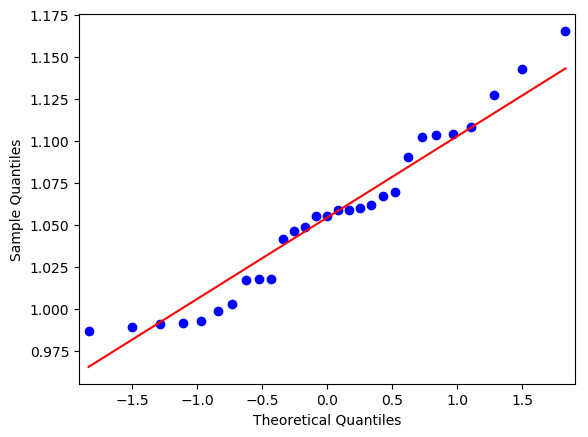

In [120]:
# relative t-test after removing 2 medium trials from participant 4's trials
pupilSize_medium = df_data.pupil_relative[df_data.score_LIX==2].tolist()
pupilSize_mediumNew = [item for sublist in [pupilSize_medium[0:20], pupilSize_medium[22:]] for item in sublist]
print(stats.ttest_rel(df_data.pupil_relative[df_data.score_LIX==1], pupilSize_mediumNew))

# checking the normality of the data:

qqplot(np.asarray(pupilSize_mediumNew), line='s') # medium difficulty
#qqplot(np.asarray(df_data.pupil_relative[df_data.score_LIX==1]), line='s') # easy difficulty


In [30]:
scoreComplexity_difficult = list()
scoreDifficulty_difficult = list()

            
blinkFrequency_difficult = list()
blinkDurationAverage_difficult = list()
interBlinkInterval_difficult = list()

ipa_difficult = list()
pupilMeanAbsolute_difficult = list()
pupilMeanRelative_difficult = list()

typingSpeed_difficult = list()
errorRate_difficult = list()

scoreComplexity_easy = list()
scoreDifficulty_easy = list()

            
blinkFrequency_easy = list()
blinkDurationAverage_easy = list()
interBlinkInterval_easy = list()

ipa_easy = list()
pupilMeanAbsolute_easy = list()
pupilMeanRelative_easy = list()

pupilMeanRelative_easyAll = list()
pupilMeanRelative_difficultAll = list()

typingSpeed_easy = list()
errorRate_easy = list()

subjInd = -1
for subjScores in scoreLIX_Total:
    subjInd = subjInd + 1
    
    scoreComplexity_subj_diffiult = list()
    scoreDifficulty_subj_difficult = list()
    
    blinkFrequency_subj_difficult = list()
    blinkDurationAverage_subj_difficult = list()
    interBlinkInterval_subj_difficult= list()
    ipa_subj_difficult = list()
    pupilMeanAbsolute_subj_difficult = list()
    pupilMeanRelative_subj_difficult = list()
    typingSpeed_subj_difficult = list()
    errorRate_subj_difficult = list()
    
    scoreComplexity_subj_easy = list()
    scoreDifficulty_subj_easy = list()

    blinkFrequency_subj_easy = list()
    blinkDurationAverage_subj_easy = list()
    interBlinkInterval_subj_easy = list()
    ipa_subj_easy = list()
    pupilMeanAbsolute_subj_easy = list()
    pupilMeanRelative_subj_easy = list()
    typingSpeed_subj_easy = list()
    errorRate_subj_easy = list()
    
    scoreInd = -1
    blinkDurationList = list()
    for score in subjScores:
        scoreInd = scoreInd + 1
        if score > 2:
            
            scoreComplexity_subj_diffiult.append(scoreComplexity_Total[subjInd][scoreInd+1])
            scoreDifficulty_subj_difficult.append(scoreDifficulty_Total[subjInd][scoreInd+1])
            
            blinkFrequency_subj_difficult.append(blinkFrequency_Total[subjInd][scoreInd])
            blinkDurationAverage_subj_difficult.append(blinkDurationAverage_Total[subjInd][scoreInd])
            interBlinkInterval_subj_difficult.append(interBlinkInterval_Total[subjInd][scoreInd])
            
            ipa_subj_difficult.append(ipa_Total[subjInd][scoreInd])
            pupilMeanAbsolute_subj_difficult.append(pupilMeanAbsolute_Total[subjInd][scoreInd])
            pupilMeanRelative_subj_difficult.append(pupilMeanRelative_Total[subjInd][scoreInd])
            
            typingSpeed_subj_difficult.append(typingSpeedTrial_Total[subjInd][scoreInd])
            errorRate_subj_difficult.append(mistakeTrialList_Total[subjInd][scoreInd])
            
        elif score < 2:
            scoreComplexity_subj_easy.append(scoreComplexity_Total[subjInd][scoreInd+1])
            scoreDifficulty_subj_easy.append(scoreDifficulty_Total[subjInd][scoreInd+1])
            
            blinkFrequency_subj_easy.append(blinkFrequency_Total[subjInd][scoreInd])
            blinkDurationAverage_subj_easy.append(blinkDurationAverage_Total[subjInd][scoreInd])
            interBlinkInterval_subj_easy.append(interBlinkInterval_Total[subjInd][scoreInd])
            
            ipa_subj_easy.append(ipa_Total[subjInd][scoreInd])
            pupilMeanAbsolute_subj_easy.append(pupilMeanAbsolute_Total[subjInd][scoreInd])
            pupilMeanRelative_subj_easy.append(pupilMeanRelative_Total[subjInd][scoreInd])
            
            typingSpeed_subj_easy.append(typingSpeedTrial_Total[subjInd][scoreInd])
            errorRate_subj_easy.append(mistakeTrialList_Total[subjInd][scoreInd])
            
            
        if scoreInd == len(subjScores)-1:
            scoreComplexity_difficult.append(np.mean(scoreComplexity_subj_diffiult))
            scoreDifficulty_difficult.append(np.mean(scoreDifficulty_subj_difficult))
            
            blinkFrequency_difficult.append(np.mean(blinkFrequency_subj_difficult))
            blinkDurationAverage_difficult.append(np.mean(blinkDurationAverage_subj_difficult))
            interBlinkInterval_difficult.append(np.mean(interBlinkInterval_subj_difficult))
            
            ipa_difficult.append(np.mean(ipa_subj_difficult))
            pupilMeanAbsolute_difficult.append(np.mean(pupilMeanAbsolute_subj_difficult))
            pupilMeanRelative_difficult.append(np.mean(pupilMeanRelative_subj_difficult))
            
            typingSpeed_difficult.append(np.mean(typingSpeed_subj_difficult))
            errorRate_difficult.append(np.mean(errorRate_subj_difficult))
            
            scoreComplexity_easy.append(np.mean(scoreComplexity_subj_easy))
            scoreDifficulty_easy.append(np.mean(scoreDifficulty_subj_easy))
            
            blinkFrequency_easy.append(np.mean(blinkFrequency_subj_easy))
            blinkDurationAverage_easy.append(np.mean(blinkDurationAverage_subj_easy))
            interBlinkInterval_easy.append(np.mean(interBlinkInterval_subj_easy))
            
            ipa_easy.append(np.mean(ipa_subj_easy))
            pupilMeanAbsolute_easy.append(np.mean(pupilMeanAbsolute_subj_easy))
            pupilMeanRelative_easy.append(np.mean(pupilMeanRelative_subj_easy))
            
            pupilMeanRelative_difficultAll.append(pupilMeanRelative_subj_difficult)
            pupilMeanRelative_easyAll.append(pupilMeanRelative_subj_easy)
            
            typingSpeed_easy.append(np.mean(typingSpeed_subj_easy))
            errorRate_easy.append(np.mean(errorRate_subj_easy))

In [39]:
pupil_difficult = [item for sublist in pupilMeanRelative_difficultAll for item in sublist] 

In [40]:
pupil_easy = [item for sublist in pupilMeanRelative_easyAll for item in sublist]

In [44]:
print(np.mean(pupil_difficult), np.mean(pupil_easy), np.std(pupil_difficult), np.std(pupil_easy))

1.0365303089061575 1.0222126248897778 0.06437362268415782 0.07715050635038173


In [36]:
mean_diff_list = list()
difficult_max_list = list()
easy_min_list = list()

for i in range(0, len(pupilMeanRelative_easyAll)):
    mean_diff_list.append(np.max(pupilMeanRelative_difficultAll[i])-np.min(pupilMeanRelative_easyAll[i]))
    difficult_max_list.append(np.max(pupilMeanRelative_difficultAll[i]))
    easy_min_list.append(np.min(pupilMeanRelative_easyAll[i]))

In [38]:
print(np.mean(difficult_max_list), np.mean(easy_min_list))

1.080008678116044 0.9959488823263063


In [ ]:
print('scores')
print(stats.ttest_rel(scoreComplexity_difficult, scoreComplexity_easy))
scoreComplexityDiff = [scoreComplexity_difficult[i] - scoreComplexity_easy[i] for i in range(0, len(scoreComplexity_easy))]
print(np.mean(scoreComplexityDiff), np.std(scoreComplexityDiff))

print(stats.ttest_rel(scoreDifficulty_difficult, scoreDifficulty_easy))
scoreDifficultyDiff = [scoreDifficulty_difficult[i]-scoreDifficulty_easy[i] for i in range(0, len(scoreDifficulty_easy))]
print(np.mean(scoreDifficultyDiff), np.std(scoreDifficultyDiff))

print('blinks')
print(stats.ttest_rel(blinkFrequency_difficult, blinkFrequency_easy))
blinkFrequencyDiff = [blinkFrequency_difficult[i]-blinkFrequency_easy[i] for i in range(0, len(blinkFrequency_easy))]
print(np.mean(blinkFrequencyDiff), np.std(blinkFrequencyDiff))
print(stats.ttest_rel(blinkDurationAverage_difficult, blinkDurationAverage_easy))
print(stats.ttest_rel(interBlinkInterval_difficult, interBlinkInterval_easy))

print('pupils')
print(stats.ttest_rel(ipa_difficult, ipa_easy))
ipaDiff = [ipa_difficult[i]-ipa_easy[i] for i in range(0, len(ipa_easy))]
print(np.mean(ipaDiff),np.std(ipaDiff))

print(stats.ttest_rel(pupilMeanAbsolute_difficult, pupilMeanAbsolute_easy))
pupilMeanAbsoluteDiff = [pupilMeanAbsolute_difficult[i]-pupilMeanAbsolute_easy[i] for i in range(0, len(pupilMeanAbsolute_easy))]
print(np.mean(pupilMeanAbsoluteDiff), np.std(pupilMeanAbsoluteDiff))
print(np.mean(pupilMeanAbsolute_difficult), np.std(pupilMeanAbsolute_difficult), np.mean(pupilMeanAbsolute_easy), np.std(pupilMeanAbsolute_easy))

print(stats.ttest_rel(pupilMeanRelative_difficult, pupilMeanRelative_easy))
pupilMeanRelativeDiff = [pupilMeanRelative_difficult[i]-pupilMeanRelative_easy[i] for i in range(0, len(pupilMeanRelative_easy))]
print(np.mean(pupilMeanRelative_difficult), np.std(pupilMeanRelative_difficult), np.mean(pupilMeanRelative_easy), np.std(pupilMeanRelative_easy))
print(np.mean(pupilMeanRelativeDiff), np.std(pupilMeanRelativeDiff))

print("typing performance")
print(stats.ttest_rel(typingSpeed_difficult, typingSpeed_easy))
print(np.mean(typingSpeed_difficult), np.std(typingSpeed_difficult), np.mean(typingSpeed_easy), np.std(typingSpeed_easy))
print(stats.ttest_rel(errorRate_difficult, errorRate_easy))
print(np.mean(errorRate_difficult), np.std(errorRate_difficult), np.mean(errorRate_easy), np.std(errorRate_easy))

In [ ]:
len([pupilMeanRelative_easy + pupilMeanRelative_difficult][0])

In [ ]:
import numpy as np
ages = [32, 26, 27, 23, 35, 28, 27]
print(np.mean(ages), np.std(ages))

In [ ]:


#scoreSubjective = [scoreDifficulty[i] + scoreComplexity[i] for i in range(0, len(scoreDifficulty))]

In [ ]:
scoreComplexity_easy = scoreComplexity_wChinRest_easy + scoreComplexity_woChinRest_easy
scoreDifficulty_easy = scoreDifficulty_wChinRest_easy + scoreDifficulty_woChinRest_easy


In [ ]:
print(len(scoreDifficulty_wChinRest_difficult))

In [ ]:
scoreLIX = [3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1]

In [ ]:
print(stats.pearsonr(scoreDifficulty, scoreLIX))
print(stats.pearsonr(scoreComplexity, scoreLIX))
#print(stats.pearsonr(scoreSubjective, scoreLIX))

In [ ]:

chinRest = [1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0]
scoreLIX = [1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0]

scoreDifficulty_anova = scoreDifficulty_difficult + scoreDifficulty_easy
scoreComplexity_anova = scoreComplexity_difficult + scoreComplexity_easy

blinkFrequency_anova = blinkFrequency_difficult + blinkFrequency_easy
interBlinkInterval_anova = interBlinkInterval_difficult + interBlinkInterval_easy

pupilMeanAbsolute_anova = pupilMeanAbsolute_difficult + pupilMeanAbsolute_easy
pupilMeanRelative_anova = pupilMeanRelative_difficult + pupilMeanRelative_easy

ipa_anova = ipa_difficult + ipa_easy

typingSpeed_anova = typingSpeed_difficult + typingSpeed_easy
errorRate_anova = errorRate_difficult + errorRate_easy



In [ ]:
scoreLIX = [3,3,3,3,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,1]

print(stats.pearsonr(scoreDifficulty, scoreLIX))
print(stats.pearsonr(scoreComplexity, scoreLIX))
print(stats.pearsonr(blinkFrequency_anova, scoreLIX))
print(stats.pearsonr(interBlinkInterval_anova, scoreLIX))
print(stats.pearsonr(pupilMeanAbsolute_anova, scoreLIX))
print(stats.pearsonr(pupilMeanRelative_anova, scoreLIX))
print(stats.pearsonr(ipa_anova, scoreLIX))
print(stats.pearsonr(typingSpeed_anova, scoreLIX))
print(stats.pearsonr(errorRate_anova, scoreLIX))


In [ ]:
plt.plot(np.arange(1,11), pupilMeanRelative_anova[0:10], '*')
plt.plot(np.arange(1,11), pupilMeanRelative_anova[10:21], 'o')


In [ ]:
plt.plot(np.arange(1,11), typingSpeed_anova[0:10], '*')
plt.plot(np.arange(1,11), typingSpeed_anova[10:21], 'o')


In [ ]:
array_svm = np.array([scoreDifficulty_anova, scoreComplexity_anova, blinkFrequency_anova, interBlinkInterval_anova, pupilMeanAbsolute_anova,
            pupilMeanRelative_anova, ipa_anova, typingSpeed_anova, errorRate_anova])

In [ ]:
list_svm = list()

for i in range(0, 20):
    inner_list = list()
        
    #inner_list.append(scoreDifficulty[i])
    #inner_list.append(scoreComplexity[i])
    inner_list.append(blinkFrequency_anova[i])
    inner_list.append(interBlinkInterval_anova[i])
    inner_list.append(pupilMeanAbsolute_anova[i])
    inner_list.append(pupilMeanRelative_anova[i])
    inner_list.append(ipa_anova[i])
    inner_list.append(typingSpeed_anova[i])
    inner_list.append(errorRate_anova[i])
    
    list_svm.append(inner_list)
    
array_svm = np.array(list_svm)

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X = array_svm
y = scoreLIX

fitScore = list()

for i in range(0,10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None)

    clf = svm.SVC(random_state=None, kernel='rbf')
    clf.fit(X_train, y_train) 
    #print(clf.predict(X_test))
    
    fitScore.append(clf.score(X_test, y_test))
    
print(np.mean(fitScore), np.std(fitScore))

In [ ]:
# k fold cross validation

from sklearn.model_selection import KFold # import KFold

fitScore = list()

kf = KFold(n_splits=10, shuffle=True, random_state=None)

for train_index, test_index in kf.split(X):
    print('TEST:', test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
    
    clf = svm.SVC(random_state=None, kernel='rbf')
    clf.fit(X_train, y_train) 
    #print(clf.predict(X_test))
    
    fitScore.append(clf.score(X_test, y_test))
    
print(np.mean(fitScore), np.std(fitScore))

In [ ]:
Df_anova = pd.DataFrame({'blinkFrequency': blinkFrequency_anova, 'interBlinkInterval' : interBlinkInterval_anova, 'pupilAbsolute' : pupilMeanAbsolute_anova, 'pupilRelative':pupilMeanRelative_anova, 'ipa':ipa_anova, 'typingSpeed' : typingSpeed_anova, 'errorRate': errorRate_anova, 'scoreDifficulty': scoreDifficulty, 'scoreComplexity': scoreComplexity })

In [ ]:
# 2-way anova 
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols



In [ ]:
model_blinkFrequency = ols('blinkFrequency_anova ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_blinkFrequency, typ=2)
print(table)

In [ ]:
model_interBlinkInterval = ols('interBlinkInterval_anova ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_interBlinkInterval, typ=2)
print(table)

In [ ]:
model_pupilAbsolute = ols('pupilMeanAbsolute_anova ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_pupilAbsolute, typ=2)
print(table)

In [ ]:
model_pupilRelative = ols('pupilMeanRelative_anova ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_pupilRelative, typ=2)
print(table)

In [ ]:
model_ipa = ols('ipa_anova ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_ipa, typ=2)
print(table)

In [ ]:
model_Complexity= ols('scoreComplexity ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_Complexity, typ=2)
print(table)

In [ ]:
model_Difficulty= ols('scoreDifficulty ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_Difficulty, typ=2)
print(table)

In [ ]:
model_TypingSpeed = ols('typingSpeed ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_TypingSpeed, typ = 2)
print(table)

In [ ]:
model_errorRate = ols('errorRate ~ C(chinRest)*C(scoreLIX)', Df_anova).fit()
table = sm.stats.anova_lm(model_errorRate, typ = 2)
print(table)

In [ ]:
# create data for plotting
blinkFrequency_plotMean = [[np.mean(blinkFrequency_easy), np.mean(blinkFrequency_wChinRest_easy), np.mean(blinkFrequency_woChinRest_easy)],
                          [ np.mean(blinkFrequency_difficult), np.mean(blinkFrequency_wChinRest_difficult), np.mean(blinkFrequency_woChinRest_difficult)]]

blinkFrequency_plotStd = [[np.std(blinkFrequency_easy), np.std(blinkFrequency_wChinRest_easy), np.std(blinkFrequency_woChinRest_easy)],
                          [ np.std(blinkFrequency_difficult), np.std(blinkFrequency_wChinRest_difficult), np.std(blinkFrequency_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
X = np.arange(3)
p1 = ax.bar(X + 0.00, blinkFrequency_plotMean[0], yerr = blinkFrequency_plotStd[0], color = 'orange', width = 0.20)
p2 = ax.bar(X + 0.25, blinkFrequency_plotMean[1], yerr = blinkFrequency_plotStd[1], color = 'g', width = 0.20)

ax.set_ylabel('Blink frequency [in Hz]')
ax.set_xticks([0.125, 1.125, 2.125])
#ax.set_xticklabels({'overall', 'with chin rest', 'without chin rest'})
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

blinkFrequency_stdmax = max(max(blinkFrequency_plotStd))
blinkFrequency_meanmax = max(max(blinkFrequency_plotMean))
ax.set_ylim([0, blinkFrequency_meanmax + blinkFrequency_stdmax+0.11])

ax.legend((p1[0], p2[0]), ('easy', 'difficult') )

ax.text((2.125), np.mean(blinkFrequency_woChinRest_easy) + np.std(blinkFrequency_woChinRest_easy)+0.04, "*", ha='center', va='bottom', color='k', fontsize = 20)
plt.tight_layout()
fig.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\blinkFrequency.png', dpi = 300, bbox_to_anchor = (0.9, 0.1))

#plt.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\blinkFrequency.png', format='png', dpi=1000)


In [ ]:
a = ax.get_xticks()
print(a)

In [ ]:
# create data for plotting
interBlinkInterval_plotMean = [[np.mean(interBlinkInterval_easy), np.mean(interBlinkInterval_wChinRest_easy), np.mean(interBlinkInterval_woChinRest_easy)],
                          [ np.mean(interBlinkInterval_difficult), np.mean(interBlinkInterval_wChinRest_difficult), np.mean(interBlinkInterval_woChinRest_difficult)]]

interBlinkInterval_plotStd = [[np.std(interBlinkInterval_easy), np.std(interBlinkInterval_wChinRest_easy), np.std(interBlinkInterval_woChinRest_easy)],
                          [ np.std(interBlinkInterval_difficult), np.std(interBlinkInterval_wChinRest_difficult), np.std(interBlinkInterval_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
X = np.arange(3)
ax.bar(X + 0.00, interBlinkInterval_plotMean[0], yerr = interBlinkInterval_plotStd[0], color = 'orange', width = 0.20)
ax.bar(X + 0.25, interBlinkInterval_plotMean[1], yerr = interBlinkInterval_plotStd[1], color = 'g', width = 0.20)

ax.set_ylabel('Inter-blink interval [in s]')
#ax.set_xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

interBlinkInterval_max = max(max(interBlinkInterval_plotStd))
ax.set_ylim([-1, interBlinkInterval_max+15])

#ax.set_.text((2.125), np.mean(interBlinkInterval_woChinRest_easy) + np.std(interBlinkInterval_woChinRest_easy)+0.03, "*", ha='center', va='bottom', color='k', fontsize = 20)



In [ ]:
# create data for plotting
pupilMeanAbsolute_plotMean = [[np.mean(pupilMeanAbsolute_easy), np.mean(pupilMeanAbsolute_wChinRest_easy), np.mean(pupilMeanAbsolute_woChinRest_easy)],
                          [ np.mean(pupilMeanAbsolute_difficult), np.mean(pupilMeanAbsolute_wChinRest_difficult), np.mean(pupilMeanAbsolute_woChinRest_difficult)]]

pupilMeanAbsolute_plotStd = [[np.std(pupilMeanAbsolute_easy), np.std(pupilMeanAbsolute_wChinRest_easy), np.std(pupilMeanAbsolute_woChinRest_easy)],
                          [ np.std(pupilMeanAbsolute_difficult), np.std(pupilMeanAbsolute_wChinRest_difficult), np.std(pupilMeanAbsolute_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
plt.rcParams.update({'font.size': 15})
X = np.arange(3)
p1 = ax.bar(X + 0.00, pupilMeanAbsolute_plotMean[0], yerr = pupilMeanAbsolute_plotStd[0], color = 'orange', width = 0.20)
p2 = ax.bar(X + 0.25, pupilMeanAbsolute_plotMean[1], yerr = pupilMeanAbsolute_plotStd[1], color = 'g', width = 0.20)


ax.set_ylabel('Absolute pupil size [in mm]')
ax.set_xticks([0.125, 1.125, 2.125])
#ax.set_xticklabels({'overall', 'with chin rest', 'without chin rest'})
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

pupilMeanAbsolute_stdmax = max(max(pupilMeanAbsolute_plotStd))
pupilMeanAbsolute_meanmax = max(max(pupilMeanAbsolute_plotMean))
ax.set_ylim([0, pupilMeanAbsolute_meanmax+pupilMeanAbsolute_stdmax+3])

ax.legend((p1[0], p2[0]), ('easy', 'difficult') )

ax.text((0.125), np.mean(pupilMeanAbsolute_easy) + np.std(pupilMeanAbsolute_easy)+0.5, "***", ha='center', va='bottom', color='k', fontsize = 20)
ax.text((2.125), np.mean(pupilMeanAbsolute_woChinRest_easy) + np.std(pupilMeanAbsolute_woChinRest_easy)+0.5, "**", ha='center', va='bottom', color='k', fontsize = 20)

plt.tight_layout()
fig.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\pupilSize.png', dpi = 300, bbox_to_anchor = (0.95, 0.1))
#plt.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\pupilSize', format='eps', dpi=1000)

In [ ]:
# create data for plotting
ipa_plotMean = [[np.mean(ipa_easy), np.mean(ipa_wChinRest_easy), np.mean(ipa_woChinRest_easy)],
                          [ np.mean(ipa_difficult), np.mean(ipa_wChinRest_difficult), np.mean(ipa_woChinRest_difficult)]]

ipa_plotStd = [[np.std(ipa_wChinRest_easy), np.std(ipa_wChinRest_easy), np.std(ipa_woChinRest_easy)],
                          [ np.std(ipa_difficult), np.std(ipa_wChinRest_difficult), np.std(ipa_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
X = np.arange(3)
p1 = ax.bar(X + 0.00, ipa_plotMean[0], yerr = ipa_plotStd[0], color = 'orange', width = 0.20)
p2 = ax.bar(X + 0.25, ipa_plotMean[1], yerr = ipa_plotStd[1], color = 'g', width = 0.20)

ax.set_ylabel('IPA values [in Hz]')
ax.set_xticks([0.125, 1.125, 2.125])
#ax.set_xticklabels({'overall', 'with chin rest', 'without chin rest'})
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

ipa_stdmax = max(max(ipa_plotStd))
ipa_meanmax = max(max(ipa_plotMean))
ax.set_ylim([0, ipa_meanmax+ipa_stdmax+0.025])

ax.legend((p1[0], p2[0]), ('easy', 'difficult') )
plt.tight_layout()
ax.text((2.125), np.mean(ipa_woChinRest_easy) + np.std(ipa_woChinRest_easy)+0.01, "*", ha='center', va='bottom', color='k', fontsize = 20)
plt.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\ipa.png', format='png', dpi=1000)


In [ ]:
# create data for plotting
scoreComplexity_plotMean = [[np.mean(scoreComplexity_easy), np.mean(scoreComplexity_wChinRest_easy), np.mean(scoreComplexity_woChinRest_easy)],
                          [ np.mean(scoreComplexity_difficult), np.mean(scoreComplexity_wChinRest_difficult), np.mean(scoreComplexity_woChinRest_difficult)]]

scoreComplexity_plotStd = [[np.std(scoreComplexity_easy), np.std(scoreComplexity_wChinRest_easy), np.std(scoreComplexity_woChinRest_easy)],
                          [ np.std(scoreComplexity_difficult), np.std(scoreComplexity_wChinRest_difficult), np.std(scoreComplexity_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
X = np.arange(3)
p1 = ax.bar(X + 0.00, scoreComplexity_plotMean[0], yerr = scoreComplexity_plotStd[0], color = 'orange', width = 0.20)
p2 = ax.bar(X + 0.25, scoreComplexity_plotMean[1], yerr = scoreComplexity_plotStd[1], color = 'g', width = 0.20)

ax.set_ylabel('Expected task complexity score [A.U.]')
ax.set_xticks([0.125, 1.125, 2.125])
#ax.set_xticklabels({'overall', 'with chin rest', 'without chin rest'})
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

scoreComplexity_stdmax = max(max(scoreComplexity_plotStd))
scoreComplexity_meanmax = max(max(scoreComplexity_plotMean))
ax.set_ylim([0, scoreComplexity_meanmax+scoreComplexity_stdmax+4])

ax.legend((p1[0], p2[0]), ('easy', 'difficult') )
plt.tight_layout()
ax.text((0.125), np.mean(scoreComplexity_easy) + np.std(scoreComplexity_easy)+3, "**", ha='center', va='bottom', color='k', fontsize = 20)
ax.text((2.125), np.mean(scoreComplexity_easy) + np.std(scoreComplexity_easy)+3, "***", ha='center', va='bottom', color='k', fontsize = 20)

fig.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\Complexity.png', dpi = 300, bbox_to_anchor = (0.95, 0.1))


In [ ]:
# create data for plotting
scoreDifficulty_plotMean = [[np.mean(scoreDifficulty_easy), np.mean(scoreDifficulty_wChinRest_easy), np.mean(scoreDifficulty_woChinRest_easy)],
                          [ np.mean(scoreDifficulty_difficult), np.mean(scoreDifficulty_wChinRest_difficult), np.mean(scoreDifficulty_woChinRest_difficult)]]

scoreDifficulty_plotStd = [[np.std(scoreDifficulty_easy), np.std(scoreDifficulty_wChinRest_easy), np.std(scoreDifficulty_woChinRest_easy)],
                          [ np.std(scoreDifficulty_difficult), np.std(scoreDifficulty_wChinRest_difficult), np.std(scoreDifficulty_woChinRest_difficult)]]

# plots
fig = plt.figure()
ax = fig.add_subplot(111)
X = np.arange(3)
p1 = ax.bar(X + 0.00, scoreDifficulty_plotMean[0], yerr = scoreDifficulty_plotStd[0], color = 'orange', width = 0.20)
p2 = ax.bar(X + 0.25, scoreDifficulty_plotMean[1], yerr = scoreDifficulty_plotStd[1], color = 'g', width = 0.20)

ax.set_ylabel('Subjective task difficulty score [A.U.]')
ax.set_xticks([0.125, 1.125, 2.125])
#ax.set_xticklabels({'overall', 'with chin rest', 'without chin rest'})
plt.xticks([0.125, 1.125, 2.125], ['overall', 'with chin rest', 'without chin rest'])

scoreDifficulty_stdmax = max(max(scoreDifficulty_plotStd))
scoreDifficulty_meanmax = max(max(scoreDifficulty_plotMean))
ax.set_ylim([0, scoreDifficulty_meanmax+scoreDifficulty_stdmax+4])

ax.legend((p1[0], p2[0]), ('easy', 'difficult') )
plt.tight_layout()
ax.text((0.125), np.mean(scoreDifficulty_woChinRest_easy) + np.std(scoreDifficulty_woChinRest_easy)+3.7, "***", ha='center', va='bottom', color='k', fontsize = 20)
ax.text((2.125), np.mean(scoreDifficulty_woChinRest_easy) + np.std(scoreDifficulty_woChinRest_easy)+3.7, "***", ha='center', va='bottom', color='k', fontsize = 20)

fig.savefig(r'C:\DTU\Results\201812_PilotExptForMovement\Paper\CHI2019\Difficulty.png', dpi = 300, bbox_to_anchor = (0.95, 0.1))


In [31]:
# remove medium trials from all measures

ipa_ed = list()
pupilMeanAbsolute_ed = list()
pupilMeanRelative_ed = list()
                
blinkFrequency_ed = list()
blinkDurationAverage_ed = list()
interBlinkInterval_ed = list()
                
                    
scoreLIX_ed = list()
scoreComplexity_ed = list()
scoreDifficulty_ed = list()
scoreSumOfScores_ed = list()
                
timeTyping_ed = list()
typingSpeed_ed = list()

errorRate_ed = list()

subjInd = -1
for subjScores in scoreLIX_Total:
    subjInd = subjInd + 1
    
    scoreLIX_subj = list()
    scoreComplexity_subj = list()
    scoreDifficulty_subj = list()
    
    blinkFrequency_subj = list()
    blinkDurationAverage_subj = list()
    interBlinkInterval_subj= list()
    ipa_subj = list()
    pupilMeanAbsolute_subj = list()
    pupilMeanRelative_subj = list()
    
    time_subj = list()
    typingSpeed_subj = list()
    errorRate_subj = list()
    
    
    
    scoreInd = -1
    
    for score in subjScores:
        scoreInd = scoreInd + 1
        if score != 2:
            
            scoreLIX_subj.append(score)
            scoreComplexity_subj.append(scoreComplexity_Total[subjInd][scoreInd+1])
            scoreDifficulty_subj.append(scoreDifficulty_Total[subjInd][scoreInd+1])
            
            blinkFrequency_subj.append(blinkFrequency_Total[subjInd][scoreInd])
            blinkDurationAverage_subj.append(blinkDurationAverage_Total[subjInd][scoreInd])
            interBlinkInterval_subj.append(interBlinkInterval_Total[subjInd][scoreInd])
            
            ipa_subj.append(ipa_Total[subjInd][scoreInd])
            pupilMeanAbsolute_subj.append(pupilMeanAbsolute_Total[subjInd][scoreInd])
            pupilMeanRelative_subj.append(pupilMeanRelative_Total[subjInd][scoreInd])
            
            time_subj.append(timeTypingTrial_Total[subjInd][scoreInd])
            typingSpeed_subj.append(typingSpeedTrial_Total[subjInd][scoreInd])
            errorRate_subj.append(mistakeTrialList_Total[subjInd][scoreInd])
            
        
        if scoreInd == len(subjScores)-1:
            scoreLIX_ed.append(scoreLIX_subj)
            scoreComplexity_ed.append(scoreComplexity_subj)
            scoreDifficulty_ed.append(scoreDifficulty_subj)
            
            blinkFrequency_ed.append(blinkFrequency_subj)
            blinkDurationAverage_ed.append(blinkDurationAverage_subj)
            interBlinkInterval_ed.append(interBlinkInterval_subj)
            
            ipa_ed.append(ipa_subj)
            pupilMeanAbsolute_ed.append(pupilMeanAbsolute_subj)
            pupilMeanRelative_ed.append(pupilMeanRelative_subj)
            
            timeTyping_ed.append(time_subj)
            typingSpeed_ed.append(typingSpeed_subj)
            errorRate_ed.append(errorRate_subj)
            


[[0.0006591165944361684,
  0.0011565544663365468,
  0.0020955069987170683,
  0.004353354370030242,
  0.0026181155982945245,
  0.0011066172221829054],
 [0.0028083588224684535,
  0.002433619192963668,
  0.0012495849206909508,
  0.0037859949231738937,
  0.0020516709291985274,
  0.0022432391465627296],
 [0.0, 0.0007000747362738336, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0007540703018234249, 0.0004223602358951047],
 [0.0002678129992165701,
  0.003692735423452837,
  0.0006841819904494736,
  0.0019119365468028395,
  0.0,
  0.00034799363614850546],
 [0.00015132961617796695,
  0.0005917717219278881,
  0.004004437261786715,
  0.0005926580346829929,
  0.0011613796335217226,
  0.0032571680627844417],
 [0.0, 0.0, 0.0, 0.0, 0.0001588071815239873],
 [0.0014798808796397842, 0.0, 0.0, 0.0, 0.0, 0.000485902866662257],
 [0.0008193567891506299,
  0.0,
  0.000687975498001533,
  0.0,
  0.000825098822030908,
  0.001883923651217131],
 [0.0,
  0.001659471001612876,
  0.0004335371018407179,
  0.0001928344

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(typingSpeed_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(pupilMeanRelative_ed[i], scoreLIX_ed[i]))

In [31]:
wChinRest1 = list()
woChinRest1 = list()

for i in range(0, 10):
    #print(stats.pearsonr(pupilMeanRelative_Total[i], scoreLIX_Total[i]))
    if i % 2 == 0:
        wChinRest1.append(stats.pearsonr(pupilMeanRelative_Total[i], scoreLIX_Total[i]))
    else:
        woChinRest1.append(stats.pearsonr(pupilMeanRelative_Total[i], scoreLIX_Total[i]))
        
print(np.mean(wChinRest1), np.mean(woChinRest1))

wChinRest2 = list()
woChinRest2 = list()

for i in range(0, 10):
    #print(stats.pearsonr(pupilMeanRelative_Total[i], scoreLIX_Total[i]))
    if i % 2 == 0:
        wChinRest2.append(stats.pearsonr(pupilMeanRelative_Total[i], scoreDifficulty_Total[i]))
    else:
        woChinRest2.append(stats.pearsonr(pupilMeanRelative_Total[i], scoreDifficulty_Total[i]))
        
print(np.mean(wChinRest2), np.mean(woChinRest2))

0.4035966981677491 0.3842659439679448
0.28869910353606576 0.36387681613769074


In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(pupilMeanAbsolute_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(blinkFrequency_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(interBlinkInterval_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(blinkDurationAverage_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(errorRate_ed[i], scoreLIX_ed[i]))

In [ ]:
for i in range(0, 10):
    print(stats.pearsonr(ipa_ed[i], scoreLIX_ed[i]))


In [ ]:
ipa_pEasy = list()
pupilMeanAbsolute_pEasy = list()
pupilMeanRelative_pEasy = list()
                
blinkFrequency_pEasy = list()
blinkDurationAverage_pEasy = list()
interBlinkInterval_pEasy = list()              
                    
scoreLIX_pEasy = list()
scoreComplexity_pEasy = list()
scoreDifficulty_pEasy = list()
scoreSumOfScores_pEasy = list()
                
timeTyping_pEasy = list()
typingSpeed_pEasy = list()
errorRate_pEasy = list()


ipa_pDifficult = list()
pupilMeanAbsolute_pDifficult = list()
pupilMeanRelative_pDifficult = list()
                
blinkFrequency_pDifficult = list()
blinkDurationAverage_pDifficult = list()
interBlinkInterval_pDifficult = list()              
                    
scoreLIX_pDifficult = list()
scoreComplexity_pDifficult = list()
scoreDifficulty_pDifficult = list()
scoreSumOfScores_pDifficult = list()
                
timeTyping_pDifficult = list()
typingSpeed_pDifficult = list()
errorRate_pDifficult = list()


for i in range(0, 9, 2):
    
    scoreLIX_subjEasy = list()
    scoreComplexity_subjEasy = list()
    scoreDifficulty_subjEasy = list()
    
    blinkFrequency_subjEasy = list()
    blinkDurationAverage_subjEasy = list()
    interBlinkInterval_subjEasy= list()
    ipa_subjEasy = list()
    pupilMeanAbsolute_subjEasy = list()
    pupilMeanRelative_subjEasy = list()
    
    time_subjEasy = list()
    typingSpeed_subjEasy = list()
    errorRate_subjEasy = list()
    
    
    scoreLIX_subjDifficult = list()
    scoreComplexity_subjDifficult = list()
    scoreDifficulty_subjDifficult = list()
    
    blinkFrequency_subjDifficult = list()
    blinkDurationAverage_subjDifficult = list()
    interBlinkInterval_subjDifficult= list()
    ipa_subjDifficult = list()
    pupilMeanAbsolute_subjDifficult = list()
    pupilMeanRelative_subjDifficult = list()
    
    time_subjDifficult = list()
    typingSpeed_subjDifficult = list()
    errorRate_subjDifficult = list()
    
    scoreInd = -1
    for score in scoreLIX_ed[i]:
        scoreInd = scoreInd + 1
        
        if score > 2:
            
            scoreLIX_subjDifficult.append(score)
            scoreComplexity_subjDifficult.append(scoreComplexity_ed[i][scoreInd])
            scoreDifficulty_subjDifficult.append(scoreDifficulty_ed[i][scoreInd])
            
            blinkFrequency_subjDifficult.append(blinkFrequency_ed[i][scoreInd])
            blinkDurationAverage_subjDifficult.append(blinkDurationAverage_ed[i][scoreInd])
            interBlinkInterval_subjDifficult.append(interBlinkInterval_ed[i][scoreInd])
            
            ipa_subjDifficult.append(ipa_ed[i][scoreInd])
            pupilMeanAbsolute_subjDifficult.append(pupilMeanAbsolute_ed[i][scoreInd])
            pupilMeanRelative_subjDifficult.append(pupilMeanRelative_ed[i][scoreInd])
            
            time_subjDifficult.append(timeTyping_ed[i][scoreInd])
            typingSpeed_subjDifficult.append(typingSpeed_ed[i][scoreInd])
            errorRate_subjDifficult.append(errorRate_ed[i][scoreInd])
            
            
        elif score < 2:
            
            scoreLIX_subjEasy.append(score)
            scoreComplexity_subjEasy.append(scoreComplexity_ed[i][scoreInd])
            scoreDifficulty_subjEasy.append(scoreDifficulty_ed[i][scoreInd])
            
            blinkFrequency_subjEasy.append(blinkFrequency_ed[i][scoreInd])
            blinkDurationAverage_subjEasy.append(blinkDurationAverage_ed[i][scoreInd])
            interBlinkInterval_subjEasy.append(interBlinkInterval_ed[i][scoreInd])
            
            ipa_subjEasy.append(ipa_ed[i][scoreInd])
            pupilMeanAbsolute_subjEasy.append(pupilMeanAbsolute_ed[i][scoreInd])
            pupilMeanRelative_subjEasy.append(pupilMeanRelative_ed[i][scoreInd])
            
            time_subjEasy.append(timeTyping_ed[i][scoreInd])
            typingSpeed_subjEasy.append(typingSpeed_ed[i][scoreInd])
            errorRate_subjEasy.append(errorRate_ed[i][scoreInd])
            
    
        
    scoreLIX_pDifficult.append(np.mean(scoreLIX_subjDifficult))
    scoreComplexity_pDifficult.append(np.mean(scoreComplexity_subjDifficult))
    scoreDifficulty_pDifficult.append(np.mean(scoreDifficulty_subjDifficult))
    
    blinkFrequency_pDifficult.append(np.mean(blinkFrequency_subjDifficult))
    blinkDurationAverage_pDifficult.append(np.mean(blinkDurationAverage_subjDifficult))
    interBlinkInterval_pDifficult.append(np.mean(interBlinkInterval_subjDifficult))
    
    ipa_pDifficult.append(np.mean(ipa_subjDifficult))
    pupilMeanAbsolute_pDifficult.append(np.mean(pupilMeanAbsolute_subjDifficult))
    pupilMeanRelative_pDifficult.append(np.mean(pupilMeanRelative_subjDifficult))

    typingSpeed_pDifficult.append(np.mean(typingSpeed_subjDifficult))
    timeTyping_pDifficult.append(np.mean(time_subjDifficult))
    errorRate_pDifficult.append(np.mean(errorRate_subjDifficult))
    
    scoreLIX_pEasy.append(np.mean(scoreLIX_subjEasy))
    scoreComplexity_pEasy.append(np.mean(scoreComplexity_subjEasy))
    scoreDifficulty_pEasy.append(np.mean(scoreDifficulty_subjEasy))
    
    blinkFrequency_pEasy.append(np.mean(blinkFrequency_subjEasy))
    blinkDurationAverage_pEasy.append(np.mean(blinkDurationAverage_subjEasy))
    interBlinkInterval_pEasy.append(np.mean(interBlinkInterval_subjEasy))
    
    ipa_pEasy.append(np.mean(ipa_subjEasy))
    pupilMeanAbsolute_pEasy.append(np.mean(pupilMeanAbsolute_subjEasy))
    pupilMeanRelative_pEasy.append(np.mean(pupilMeanRelative_subjEasy))

    typingSpeed_pEasy.append(np.mean(typingSpeed_subjEasy))
    timeTyping_pEasy.append(np.mean(time_subjEasy))
    errorRate_pEasy.append(np.mean(errorRate_subjEasy))
        

In [ ]:
pupilMeanRelative_pDifficult

In [ ]:
pupilMeanRelative_pEasy

In [44]:
scoreLIX_ml = [score for list1 in scoreLIX_ed for score in list1]
blinkFrequency_ml = [blink for list1 in blinkFrequency_ed for blink in list1]
blinkDurationAverage_ml = [blink for list1 in blinkDurationAverage_ed for blink in list1]
scoreComplexity_ml = [complexity for list1 in scoreComplexity_ed for complexity in list1]
scoreDifficulty_ml = [difficulty for list1 in scoreDifficulty_ed for difficulty in list1]
ipa_ml = [ipa for list1 in ipa_ed for ipa in list1]
pupilMeanRelative_ml = [pupil for list1 in pupilMeanRelative_ed for pupil in list1]
pupilMeanAbsolute_ml = [pupil for list1 in pupilMeanAbsolute_ed for pupil in list1]


In [48]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

y = [0 if score == 1 else 1 for score in scoreLIX_ml]

X = pd.DataFrame(
    {#'blinkFrequency': blinkFrequency_ml,
     #'blinkDuration': blinkDurationAverage_ml,
     'scoreComplexity': scoreComplexity_ml,
     'scoreDifficulty': scoreDifficulty_ml,
     #'ipa' : ipa_ml,
     'pupilMeanRelative' : pupilMeanRelative_ml,
     'pupilMeanAbsolute' : pupilMeanAbsolute_ml
        
     
    })


logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')

print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.387045
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.441     
Dependent Variable:  y                AIC:              53.6713   
Date:                2019-03-13 17:45 BIC:              61.9814   
No. Observations:    59               Log-Likelihood:   -22.836   
Df Model:            3                LL-Null:          -40.887   
Df Residuals:        55               LLR p-value:      7.1217e-08
Converged:           1.0000           Scale:            1.0000    
------------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025   0.975]
------------------------------------------------------------------
scoreComplexity    0.6084   0.3520  1.7284 0.0839  -0.0815  1.2983
scoreDifficulty    1.0364   0.3773  2.7468 0.0060 

In [72]:
# Import train_test_split function
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=20) # 70% training and 30% test

#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6666666666666666


In [73]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.5714285714285714
Recall: 0.8


In [74]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[4, 3],
       [1, 4]], dtype=int64)

In [85]:
accuracy_list = list()
precision_list = list()
recall_list = list()

confusionMatrix_list = list()

for i in range(0,10):
    
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 70% training and 30% test

    #Import svm model
    from sklearn import svm

    #Create a svm Classifier
    clf = svm.SVC(kernel='linear') # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    accuracy_list.append(metrics.accuracy_score(y_test, y_pred))
    precision_list.append(metrics.precision_score(y_test, y_pred))
    recall_list.append(metrics.recall_score(y_test, y_pred))
    confusionMatrix_list.append(confusion_matrix(y_test, y_pred))
    
    # Model Accuracy: how often is the classifier correct?
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    
    # Model Precision: what percentage of positive tuples are labeled as such?
    #print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    #print("Recall:",metrics.recall_score(y_test, y_pred))
    
    


Accuracy: 0.8333333333333334
Accuracy: 1.0
Accuracy: 0.8333333333333334
Accuracy: 0.8333333333333334
Accuracy: 0.75
Accuracy: 0.9166666666666666
Accuracy: 0.75
Accuracy: 0.8333333333333334
Accuracy: 0.8333333333333334
Accuracy: 0.6666666666666666


In [86]:
np.mean(accuracy_list)

0.825

In [87]:
np.mean(recall_list)

0.7629761904761905

In [88]:
np.mean(precision_list)

0.8190476190476191

In [84]:
metrics.roc_curve(y_test, y_pred)

(array([0.  , 0.25, 1.  ]), array([0. , 0.5, 1. ]), array([2, 1, 0]))